<a href="https://colab.research.google.com/github/henryonomakpo/The-Impact-of-ESG-Ratings-on-EV-Manufacturing-Industry/blob/main/RE_IRENA_ESG_PDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openpyxl
!pip install linearmodels
!pip install mapie
!pip install statsmodels
!pip install scikit-learn
!pip install seaborn
!pip install shap



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.1/178.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 57.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


### **Prepare merged dataset for Panel Regression

In [ ]:
import pandas as pd
import re
# Import the files module for downloading in Colab
from google.colab import files

# --- Configuration ---
# Assuming the input file is uploaded to the Colab session's root /content/ directory
input_filename = '/content/Geopolitical_risk_WorlBank.csv'
# Output file will also be saved to the /content/ directory first
output_filename = '/content/Geopolitical_risk_Panel.csv'
# You can change this if you mount Google Drive, e.g.:
# output_filename = '/content/drive/MyDrive/Geopolitical_risk_Panel.csv'
# (Remember to mount drive first in that case)

# --- Optional: Mount Google Drive (Uncomment if you want to save directly to Drive) ---
# from google.colab import drive
# try:
#     drive.mount('/content/drive')
#     print("Google Drive mounted successfully.")
#     # Update output_filename if saving to Drive:
#     # output_filename = '/content/drive/MyDrive/Geopolitical_risk_Panel.csv'
# except Exception as e:
#     print(f"Error mounting Google Drive: {e}")
#     print("Saving to Colab session storage instead.")
#     output_filename = '/content/Geopolitical_risk_Panel.csv' # Fallback

# --- Data Loading ---
try:
    df_wide = pd.read_csv(input_filename)
    print(f"Successfully loaded '{input_filename}'.")

    # --- Clean column names ---
    print("Original DataFrame column names:", df_wide.columns.tolist())
    original_columns = df_wide.columns.tolist()
    df_wide.columns = df_wide.columns.str.strip() # Remove leading/trailing whitespace
    cleaned_columns = df_wide.columns.tolist()
    if original_columns != cleaned_columns:
         print("Cleaned DataFrame column names:", cleaned_columns)
    # --- End Clean ---

    print("Original DataFrame shape:", df_wide.shape)
    # print("\nFirst 5 rows of original data:") # Optional: uncomment to print
    # print(df_wide.head())

except FileNotFoundError:
    print(f"Error: The file '{input_filename}' was not found.")
    print("Please ensure you have uploaded the file to your Colab session or provided the correct path (e.g., from Google Drive if mounted).")
    # Use exit() if running as a script, or just let Colab stop if in a notebook
    # exit()
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")
    # exit()

# --- Data Reshaping (Wide to Long) ---
if 'df_wide' in locals(): # Proceed only if df_wide was loaded successfully
    try:
        id_vars = ['Country', 'Geopolitical_Indicator']
        value_vars = [col for col in df_wide.columns if col.endswith('_Geopolitical_risk')]

        if not value_vars:
            print("\nError: Could not find columns ending with '_Geopolitical_risk'.")
            print("Please check the column naming convention in the input CSV.")
        else:
            print(f"\nIdentified {len(value_vars)} value columns to melt.")

            df_long = pd.melt(df_wide,
                              id_vars=id_vars,
                              value_vars=value_vars,
                              var_name='Year_Variable',
                              value_name='Geopolitical_Risk')
            print("\nDataFrame shape after melting:", df_long.shape)
            # print("First 5 rows after melting:") # Optional: uncomment to print
            # print(df_long.head())

            # --- Data Cleaning and Final Preparation ---
            df_long['Year'] = df_long['Year_Variable'].str.extract(r'(\d{4})')
            if df_long['Year'].isnull().any():
                print("\nWarning: Some 'Year' values could not be extracted from 'Year_Variable'.")

            df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')
            df_long['Geopolitical_Risk'] = pd.to_numeric(df_long['Geopolitical_Risk'], errors='coerce')

            indicator_unique_count = df_long['Geopolitical_Indicator'].nunique()
            if indicator_unique_count == 1:
                print(f"\n'Geopolitical_Indicator' column has only one unique value: '{df_long['Geopolitical_Indicator'].iloc[0]}'. Dropping it.")
                df_panel = df_long[['Country', 'Year', 'Geopolitical_Risk']].copy()
            elif indicator_unique_count > 1:
                 print(f"\n'Geopolitical_Indicator' column has {indicator_unique_count} unique values. Keeping it.")
                 df_panel = df_long[['Country', 'Geopolitical_Indicator', 'Year', 'Geopolitical_Risk']].copy()
            else:
                print("\n'Geopolitical_Indicator' column seems empty or problematic. Dropping it.")
                df_panel = df_long[['Country', 'Year', 'Geopolitical_Risk']].copy()

            df_panel = df_panel.sort_values(by=['Country', 'Year']).reset_index(drop=True)

            missing_years = df_panel['Year'].isnull().sum()
            missing_risks = df_panel['Geopolitical_Risk'].isnull().sum()
            print(f"\nNumber of rows with missing 'Year' after conversion: {missing_years}")
            print(f"Number of rows with missing 'Geopolitical_Risk' after conversion: {missing_risks}")

            print("\nFinal Panel DataFrame shape:", df_panel.shape)
            print("First 10 rows of final panel data:")
            print(df_panel.head(10))
            # print("\nLast 10 rows of final panel data:") # Optional: uncomment to print
            # print(df_panel.tail(10))

            # --- Save Processed Data to Colab Storage ---
            try:
                df_panel.to_csv(output_filename, index=False)
                print(f"\nSuccessfully saved the processed panel data to Colab session storage: '{output_filename}'.")

                # --- Trigger Download in Colab ---
                print("Attempting to trigger browser download...")
                files.download(output_filename)
                print(f"If the download doesn't start automatically, check your browser's download permissions for this site.")
                print(f"Alternatively, find '{output_filename.split('/')[-1]}' in the Colab file browser (left sidebar, folder icon) and download manually.")


            except Exception as e:
                print(f"\nAn error occurred while saving or downloading the CSV: {e}")

    except KeyError as e:
        print(f"\nError during melting: {e}")
        print("This might happen if column names were not cleaned correctly or still mismatch.")
        print("Current DataFrame columns after cleaning:", df_wide.columns.tolist())
        print("id_vars used:", id_vars)
    except Exception as e:
        print(f"\nAn unexpected error occurred during processing: {e}")

else:
    print("\nSkipping processing and saving because the input file was not loaded.")

Successfully loaded '/content/Geopolitical_risk_WorlBank.csv'.
Original DataFrame column names: ['Country', 'Geopolitical_Indicator ', '2000_Geopolitical_risk', '2001_Geopolitical_risk', '2002_Geopolitical_risk', '2003_Geopolitical_risk', '2004_Geopolitical_risk', '2005_Geopolitical_risk', '2006_Geopolitical_risk', '2007_Geopolitical_risk', '2008_Geopolitical_risk', '2009_Geopolitical_risk', '2010_Geopolitical_risk', '2011_Geopolitical_risk', '2012_Geopolitical_risk', '2013_Geopolitical_risk', '2014_Geopolitical_risk', '2015_Geopolitical_risk', '2016_Geopolitical_risk', '2017_Geopolitical_risk', '2018_Geopolitical_risk', '2019_Geopolitical_risk', '2020_Geopolitical_risk', '2021_Geopolitical_risk', '2022_Geopolitical_risk', '2023_Geopolitical_risk']
Cleaned DataFrame column names: ['Country', 'Geopolitical_Indicator', '2000_Geopolitical_risk', '2001_Geopolitical_risk', '2002_Geopolitical_risk', '2003_Geopolitical_risk', '2004_Geopolitical_risk', '2005_Geopolitical_risk', '2006_Geopoliti

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

If the download doesn't start automatically, check your browser's download permissions for this site.
Alternatively, find 'Geopolitical_risk_Panel.csv' in the Colab file browser (left sidebar, folder icon) and download manually.


### Panel Regression, Random forest and XGBoost

Running in Google Colab
--- Loading Data ---

--- Formatting ESG Data ---
Extracted ESG Headers (sample): ['Country', 'coastal_protection_2008', 'coastal_protection_2009', 'coastal_protection_2010', 'coastal_protection_2011', 'coastal_protection_2012', 'coastal_protection_2013', 'coastal_protection_2014', 'coastal_protection_2015', 'coastal_protection_2016'] ...
Read ESG data content shape: (47, 2)
Successfully processed ESG data from raw read.
ESG Data types after numeric conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Columns: 545 entries, Country to voice_and_accountability_estimate_2023
dtypes: float64(544), object(1)
memory usage: 200.2+ KB
None
Processed ESG panel data saved to ESG_panel_processed.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Offering ESG_panel_processed.csv for download in Colab.
Processed ESG Panel Head:
Indicator    Country  Year  coastal_protection  control_corruption_estimate  \
0          Australia  2009                0.00                         2.04   
1          Australia  2010                0.00                         2.02   
2          Australia  2011                0.00                         2.04   
3          Australia  2012               89.39                         1.98   
4          Australia  2013               89.39                         1.78   

Indicator  economic_and_social_rights_performance_score  \
0                                                  2.47   
1                                                  2.47   
2                                                  2.49   
3                                                  2.47   
4                                                  2.47   

Indicator  electricity_production_from_coal_sources_total  \
0                          

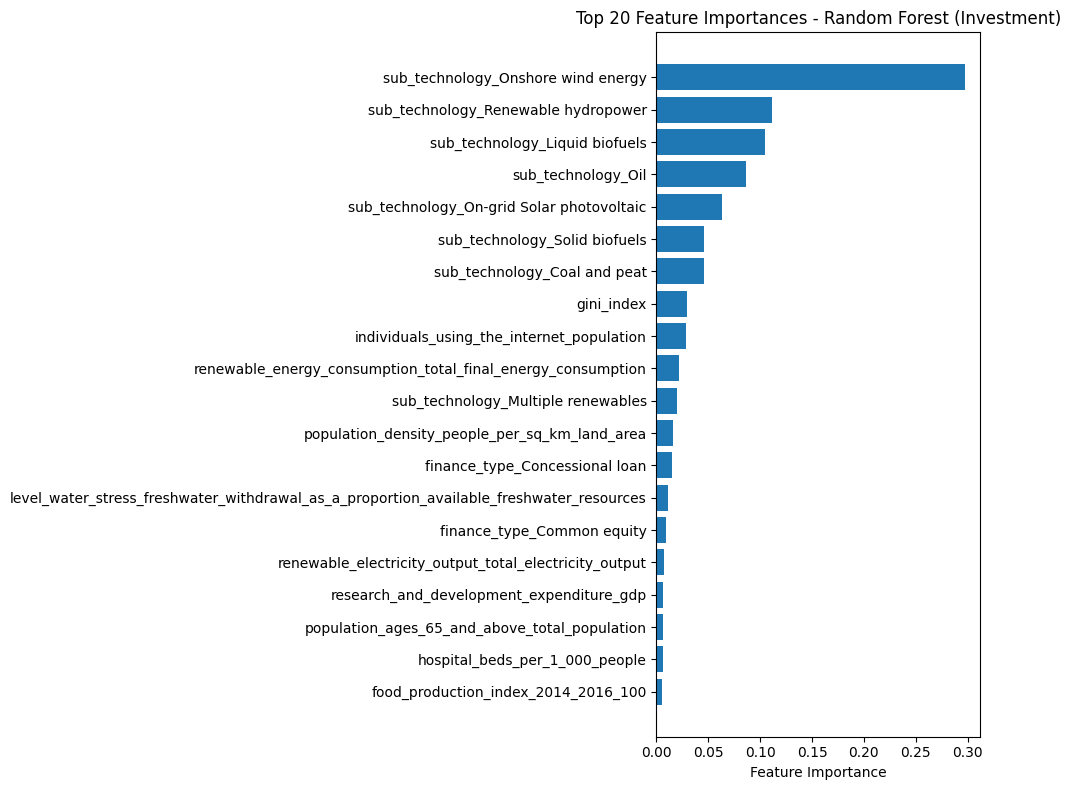

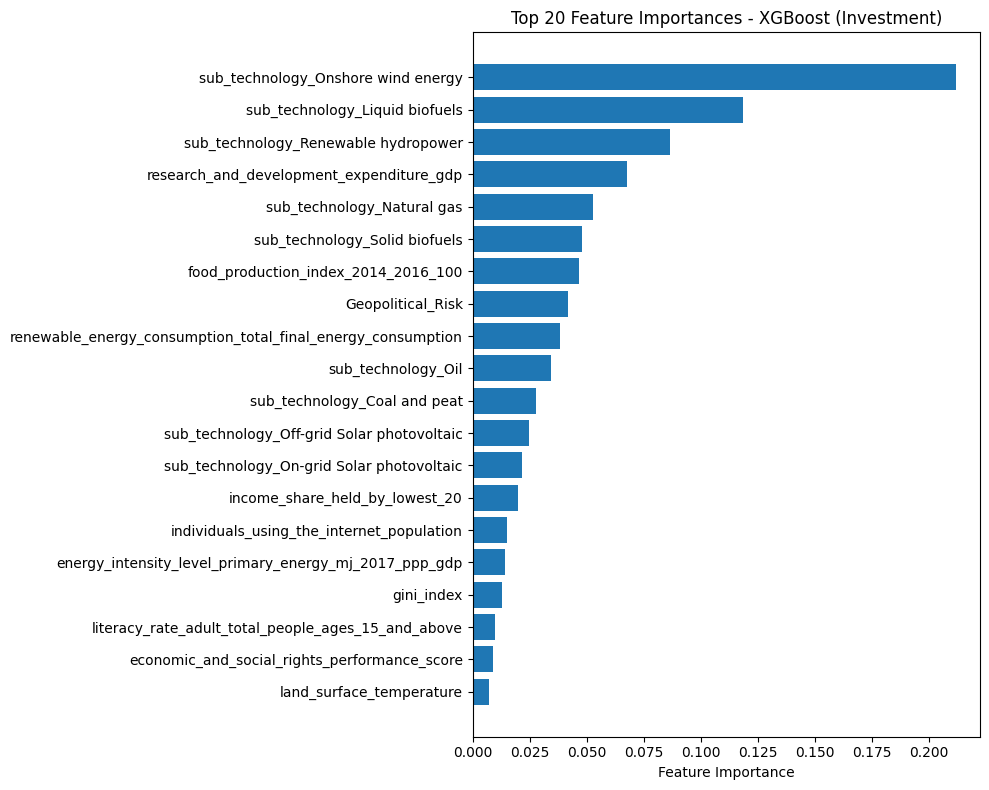

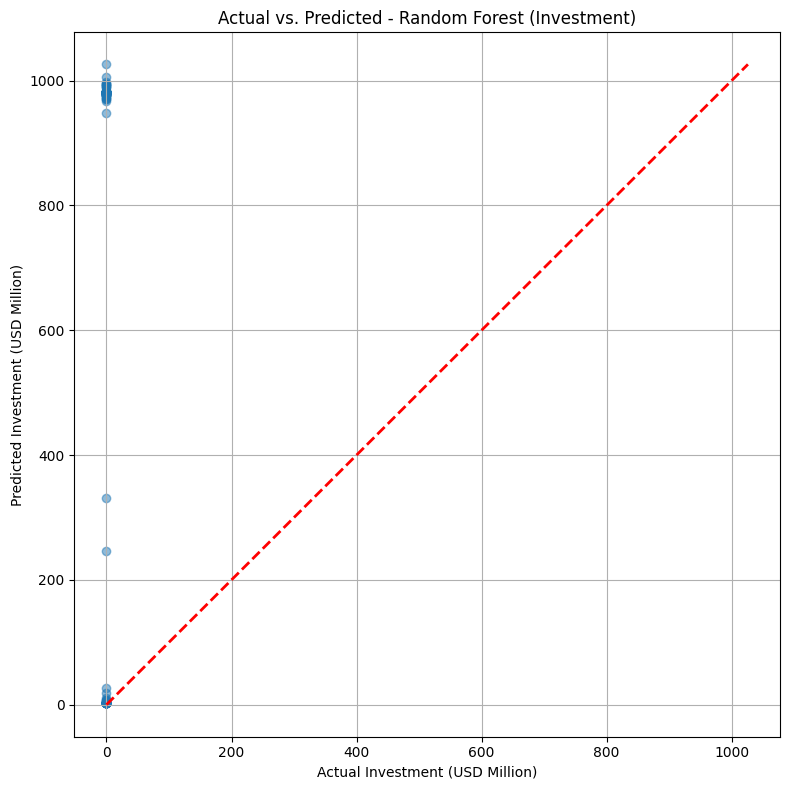

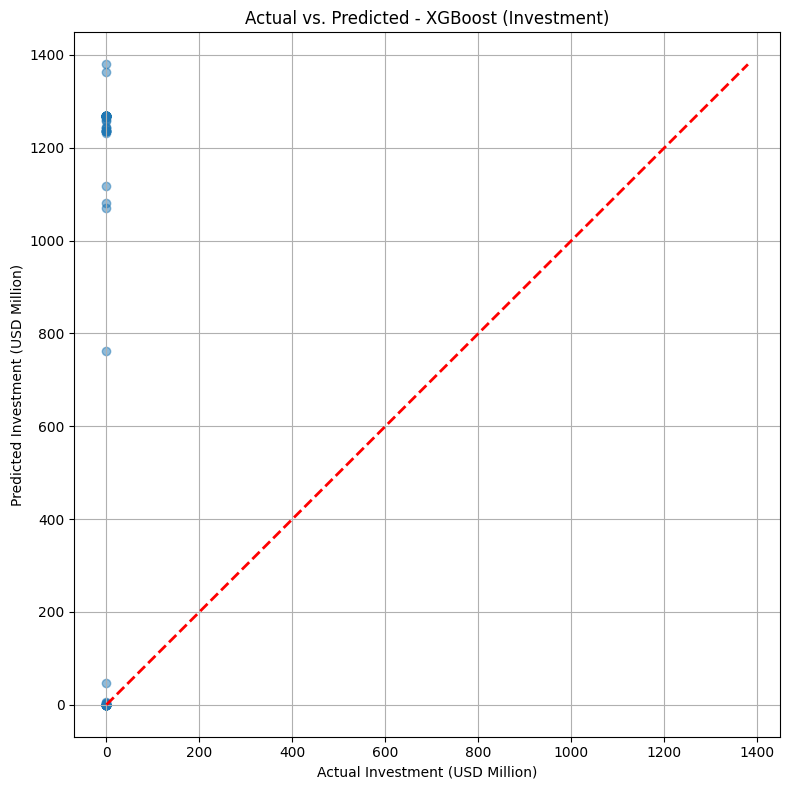

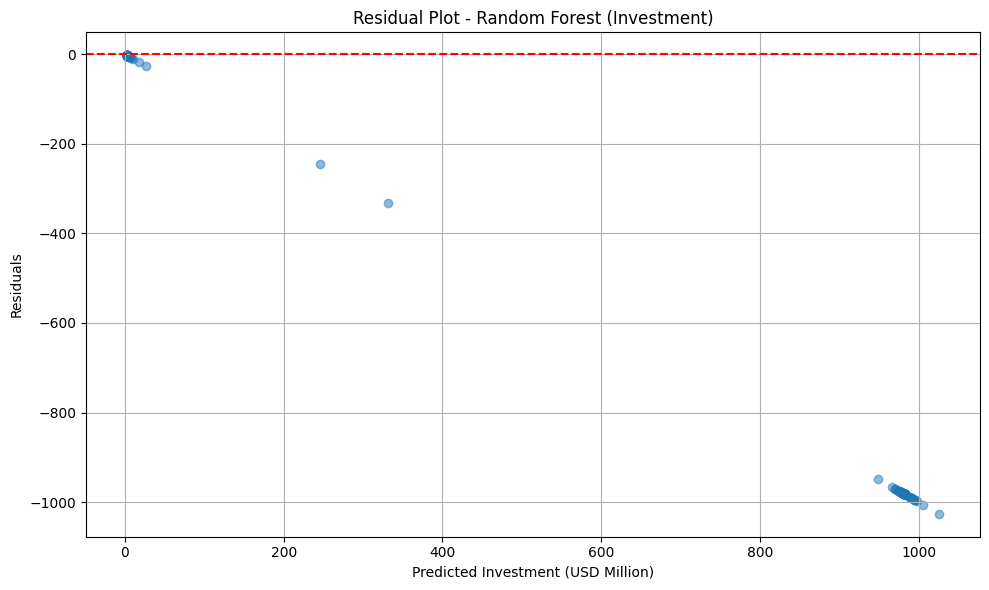

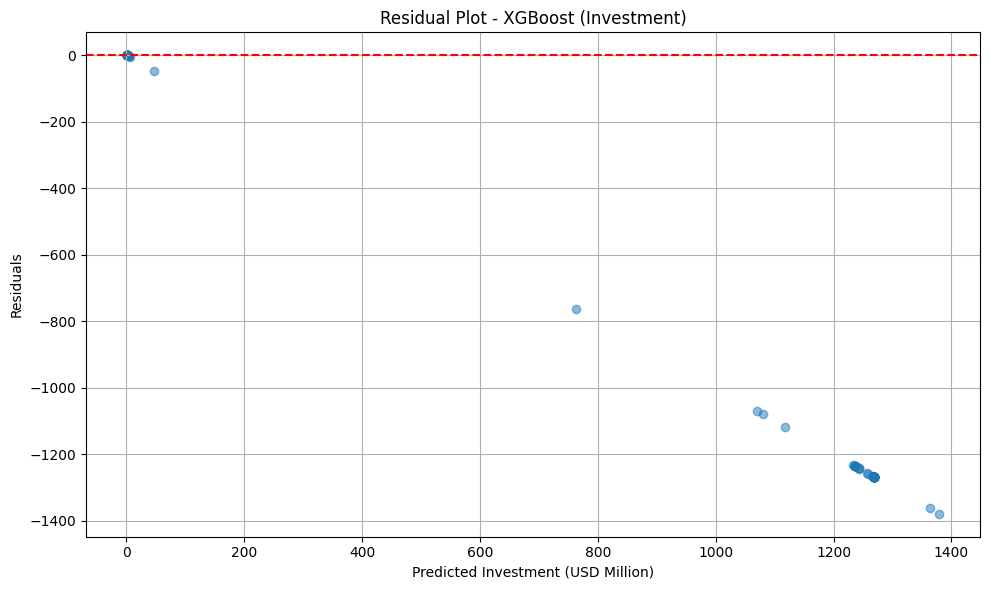


--- Analysis Complete ---


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.panel import PooledOLS, RandomEffects, PanelOLS
from linearmodels.panel.results import compare # Import compare for neat display
# from linearmodels.panel.diagnostics import cd_test # Removed this line
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
import io
import traceback
from scipy import stats # For chi-squared test (Hausman)

# --- Check if running in Colab and import files module ---
try:
    import google.colab
    IN_COLAB = True
    from google.colab import files
    print("Running in Google Colab")
except:
    IN_COLAB = False
    print("Not running in Google Colab")


warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# --- 1. Data Loading ---
print("--- Loading Data ---")
try:
    # --- Corrected ESG Data Loading and Processing ---
    print("\n--- Formatting ESG Data ---")
    with open("ESG_indicators_wide_by_year.csv", 'r') as f:
        header_line = f.readline().strip()
        try:
            quote_start_index = header_line.find('"') + 1
            quote_end_index = header_line.rfind('"')
            header_string = header_line[quote_start_index:quote_end_index]
            correct_headers = [h.strip() for h in header_string.split('\t')]
            correct_headers = ['Country'] + correct_headers[1:]
            print("Extracted ESG Headers (sample):", correct_headers[:10], "...")
        except Exception as e:
             print(f"Error parsing ESG header: {e}. Falling back to standard read.")
             correct_headers = None

        try:
            esg_data_str = f.read()
            esg_wide_df_raw = pd.read_csv(io.StringIO(esg_data_str), sep=',', quotechar='"', header=None)
            print(f"Read ESG data content shape: {esg_wide_df_raw.shape}")

            if esg_wide_df_raw.shape[1] == 2:
                 processed_data = []
                 for index, row in esg_wide_df_raw.iterrows():
                      country_raw = row[0]
                      data_string = row[1]
                      if isinstance(data_string, str):
                          split_values = [val.strip() for val in data_string.split('\t')]
                          country_actual = split_values[0]
                          processed_row = [country_actual] + split_values[1:]
                          processed_data.append(processed_row)
                      else:
                          print(f"Warning: Skipping row {index} in ESG data due to unexpected format: {row}")

                 if correct_headers and len(processed_data) > 0:
                     if len(correct_headers) == len(processed_data[0]):
                          esg_wide_df = pd.DataFrame(processed_data, columns=correct_headers)
                          print("Successfully processed ESG data from raw read.")
                     else:
                         print(f"Warning: Header length ({len(correct_headers)}) != data row length ({len(processed_data[0])}). Using generic headers.")
                         esg_wide_df = pd.DataFrame(processed_data)
                         num_cols_data = esg_wide_df.shape[1]
                         esg_wide_df.columns = ['Country'] + [f'col_{i}' for i in range(1,num_cols_data)]
                         correct_headers = esg_wide_df.columns.tolist()
                 else:
                      raise ValueError("Could not process ESG data rows or headers.")

            else:
                print("Warning: ESG read resulted in > 2 columns. Attempting standard processing.")
                esg_wide_df = pd.read_csv(io.StringIO(header_line + '\n' + esg_data_str), sep=',', quotechar='"')
                esg_wide_df.columns = [col.strip().replace('"', '') for col in esg_wide_df.columns]
                if '\t' in esg_wide_df.columns[1]:
                    print("Detected nested headers in standard read, attempting correction...")
                    first_col_name = esg_wide_df.columns[0]
                    nested_headers = esg_wide_df.columns[1].split('\t')
                    corrected_headers_std = [first_col_name] + nested_headers[1:]
                    esg_wide_df.columns = corrected_headers_std
                    print("Corrected headers based on second column content.")
                correct_headers = esg_wide_df.columns.tolist()

        except Exception as e:
            print(f"Error during detailed ESG processing: {e}. Falling back to simpler load.")
            traceback.print_exc()
            esg_wide_df = pd.read_csv("ESG_indicators_wide_by_year.csv")
            esg_wide_df.columns = esg_wide_df.columns.str.strip().str.replace('"', '')
            correct_headers = None

    # --- Proceed with Melting ---
    esg_wide_df.columns = esg_wide_df.columns.str.strip()
    id_col = 'Country'
    value_vars = [col for col in esg_wide_df.columns if col != id_col]

    for col in value_vars:
         esg_wide_df[col] = pd.to_numeric(esg_wide_df[col], errors='coerce')

    print("ESG Data types after numeric conversion:")
    print(esg_wide_df.info(verbose=False))

    esg_long = pd.melt(esg_wide_df, id_vars=[id_col], value_vars=value_vars,
                       var_name='Indicator_Year', value_name='Value')

    try:
        esg_long['Year'] = esg_long['Indicator_Year'].str.extract(r'(\d{4})$', expand=False)
        esg_long['Indicator'] = esg_long['Indicator_Year'].str.replace(r'_\d{4}$', '', regex=True)
        needs_rsplit = esg_long['Year'].isnull()
        if needs_rsplit.any():
             print("Using rsplit fallback for some Indicator_Year entries...")
             split_data_fallback = esg_long.loc[needs_rsplit, 'Indicator_Year'].str.rsplit('_', n=1, expand=True)
             if split_data_fallback.shape[1] == 2:
                 esg_long.loc[needs_rsplit, 'Indicator'] = split_data_fallback[0]
                 esg_long.loc[needs_rsplit, 'Year'] = split_data_fallback[1]
             else:
                 print("rsplit fallback also failed.")
    except Exception as e:
         print(f"Error splitting Indicator_Year: {e}. Assigning NaN to Year.")
         esg_long['Indicator'] = esg_long['Indicator_Year']
         esg_long['Year'] = np.nan

    esg_long['Year'] = pd.to_numeric(esg_long['Year'], errors='coerce')
    esg_long.dropna(subset=['Year', 'Indicator'], inplace=True)
    esg_long['Year'] = esg_long['Year'].astype(int)

    esg_long.drop('Indicator_Year', axis=1, inplace=True)
    duplicates = esg_long.duplicated(subset=[id_col, 'Year', 'Indicator'], keep=False)
    if duplicates.any(): print(f"Warning: Found {duplicates.sum()} duplicate entries. Aggregating using mean.")

    try:
        esg_panel = esg_long.pivot_table(index=[id_col, 'Year'], columns='Indicator', values='Value', aggfunc='mean').reset_index()
    except Exception as pivot_e: print(f"Error during pivoting: {pivot_e}"); exit()

    esg_panel[id_col] = esg_panel[id_col].str.strip()

    processed_esg_filename = "ESG_panel_processed.csv"
    esg_panel.to_csv(processed_esg_filename, index=False)
    print(f"Processed ESG panel data saved to {processed_esg_filename}")
    if IN_COLAB:
        try:
            files.download(processed_esg_filename)
            print(f"Offering {processed_esg_filename} for download in Colab.")
        except Exception as e:
            print(f"Colab download trigger failed: {e}")

    print("Processed ESG Panel Head:")
    print(esg_panel.head())
    print("Processed ESG Panel Info:")
    print(esg_panel.info(verbose=False))

    gpr_df = pd.read_csv("Geopolitical_risk_Panel.csv")
    investment_df = pd.read_csv("PANEL_IRENA_RE_Investment_Processed_VIF_Reduced.csv")
    print("Other data loaded successfully.")
except FileNotFoundError as e: print(f"Error loading file: {e}"); exit()
except Exception as e: print(f"Unexpected error loading/formatting: {e}"); traceback.print_exc(); exit()


# --- 3. Data Merging ---
print("\n--- Merging Data ---")
gpr_df.columns = gpr_df.columns.str.strip(); gpr_df['Country'] = gpr_df['Country'].str.strip(); gpr_df['Year'] = pd.to_numeric(gpr_df['Year'], errors='coerce'); gpr_df.dropna(subset=['Year'], inplace=True); gpr_df['Year'] = gpr_df['Year'].astype(int)
investment_df.columns = investment_df.columns.str.strip().str.replace('癤\ufeff', '', regex=False); investment_df.rename(columns={'癤?Country': 'Country'}, inplace=True); investment_df['Country'] = investment_df['Country'].str.strip(); investment_df['Year'] = pd.to_numeric(investment_df['Year'], errors='coerce'); investment_df.dropna(subset=['Year'], inplace=True); investment_df['Year'] = investment_df['Year'].astype(int)

merged_df = pd.merge(esg_panel, gpr_df, on=['Country', 'Year'], how='inner')
print(f"Shape after merging ESG and GPR: {merged_df.shape}")
if merged_df.empty: print("Warning: Merging ESG and GPR resulted in empty DataFrame.")

investment_cols_to_keep = ['Country', 'Year', 'amount_usd_million'] + [col for col in investment_df.columns if 'sub_technology' in col or 'finance_type' in col]
investment_cols_to_keep = list(dict.fromkeys(investment_cols_to_keep))
investment_subset = investment_df[investment_cols_to_keep]
final_df = pd.merge(merged_df, investment_subset, on=['Country', 'Year'], how='left')
print(f"Shape after merging with Investment data: {final_df.shape}")

# --- 4. Revised Data Imputation ---
print("\n--- Performing Improved Imputation ---")
investment_related_cols = [col for col in final_df.columns if 'sub_technology' in col or 'finance_type' in col or 'amount_usd_million' in col]
other_numeric_cols = [col for col in final_df.select_dtypes(include=np.number).columns if col not in investment_related_cols and col != 'Year']
print(f"Imputing {len(investment_related_cols)} investment cols with 0...")
final_df[investment_related_cols] = final_df[investment_related_cols].fillna(0)
target = 'amount_usd_million'
print(f"NaNs in '{target}': {final_df[target].isnull().sum()}")
print(f"Applying grouped linear interpolation to {len(other_numeric_cols)} other cols...")
final_df.sort_values(by=['Country', 'Year'], inplace=True)
final_df[other_numeric_cols] = final_df.groupby('Country')[other_numeric_cols].transform(lambda group: group.interpolate(method='linear', limit_direction='both', limit_area='inside'))
nan_counts_after_interp = final_df[other_numeric_cols].isnull().sum()
cols_needing_further_fill = nan_counts_after_interp[nan_counts_after_interp > 0].index.tolist()
if cols_needing_further_fill:
    print(f"Applying grouped median fill for remaining {len(cols_needing_further_fill)} cols...")
    grouped_medians = final_df.groupby('Country')[cols_needing_further_fill].transform('median')
    final_df[cols_needing_further_fill] = final_df[cols_needing_further_fill].fillna(grouped_medians)
nan_counts_after_median = final_df[cols_needing_further_fill].isnull().sum()
cols_still_needing_fill = nan_counts_after_median[nan_counts_after_median > 0].index.tolist()
if cols_still_needing_fill:
    print(f"Applying global median fill for {len(cols_still_needing_fill)} remaining cols...")
    global_medians = final_df[cols_still_needing_fill].median()
    final_df[cols_still_needing_fill] = final_df[cols_still_needing_fill].fillna(global_medians)
all_numeric_cols = other_numeric_cols + investment_related_cols
nan_final_check = final_df[all_numeric_cols].isnull().sum().sum()
if nan_final_check == 0: print("\nImputation complete.")
else: print(f"\nWarning: {nan_final_check} NaNs remain."); print(final_df.isnull().sum()[final_df.isnull().sum() > 0])

# --- 5. Multicollinearity Check (VIF) ---
print("\n--- Calculating VIF ---")
if target not in final_df.columns or not pd.api.types.is_numeric_dtype(final_df[target]): print(f"Error: Target '{target}' missing/non-numeric."); exit()
numeric_cols_vif = final_df.select_dtypes(include=np.number).columns.tolist()
if 'Year' in numeric_cols_vif: numeric_cols_vif.remove('Year')
potential_predictors = [col for col in numeric_cols_vif if col != target]
print("Checking for constant/low variance features...")
non_constant_predictors = []
for col in potential_predictors:
     try:
        nunique = final_df[col].nunique(dropna=False); variance = final_df[col].var(ddof=0)
        if nunique > 1 and variance > 1e-10 : non_constant_predictors.append(col)
        else: print(f"  Dropping '{col}' (Unique: {nunique}, Variance: {variance:.2e})")
     except TypeError: print(f"  Skipping non-numeric '{col}'")
X = final_df[non_constant_predictors]
if X.empty: print("Error: No predictors left after variance check."); exit()
if X.isnull().values.any() or np.isinf(X.values).any(): print("Error: NaNs/Infs in predictors before VIF."); exit()
X_with_const = sm.add_constant(X, has_constant='add')
if X_with_const.isnull().values.any() or np.isinf(X_with_const.values).any(): print("Error: NaNs/Infs after adding constant."); exit()

vif_threshold = 10; max_vif = float('inf'); features_after_vif = list(X.columns)
while len(features_after_vif) > 1:
    X_vif_subset = final_df[features_after_vif]
    if X_vif_subset.isnull().values.any() or np.isinf(X_vif_subset.values).any(): print("Error: NaNs/Infs in VIF subset."); break
    X_vif_calc = sm.add_constant(X_vif_subset, has_constant='add')
    try:
         vif_data = pd.DataFrame({'feature': X_vif_calc.columns})
         vif_data['VIF'] = [variance_inflation_factor(X_vif_calc.values, i) for i in range(X_vif_calc.shape[1])]
         vif_data = vif_data[vif_data['feature'] != 'const']
    except Exception as e: print(f"VIF Error: {e}"); break
    if vif_data.empty: print("VIF data empty. Breaking."); break
    inf_vif_features = vif_data[vif_data['VIF'] == np.inf]['feature'].tolist()
    if inf_vif_features:
        feature_to_remove = inf_vif_features[0]
        print(f"Removing '{feature_to_remove}' (infinite VIF).")
        if feature_to_remove in features_after_vif: features_after_vif.remove(feature_to_remove); continue
    max_vif = vif_data['VIF'].max()
    if max_vif > vif_threshold:
        max_vif_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'feature']
        print(f"Removing '{max_vif_feature}' (VIF: {max_vif:.2f})")
        if max_vif_feature in features_after_vif: features_after_vif.remove(max_vif_feature)
        else: break
    else: print(f"All VIFs below {vif_threshold}."); break
print(f"\nFeatures remaining after VIF reduction: {len(features_after_vif)}")
cols_to_keep_final = ['Country', 'Year', target] + features_after_vif
final_df_vif = final_df[cols_to_keep_final].copy()
if final_df_vif.drop(columns=['Country']).isnull().values.any(): print("WARNING: NaNs detected in final DF after VIF!"); exit()

# --- 6. Panel Data Regression & Diagnostics ---
print("\n--- Running Panel Data Regressions & Diagnostics (Target: amount_usd_million) ---")
models_fitted = {}
hausman_pvalue = np.nan

try:
    panel_data_indexed = final_df_vif.set_index(['Country', 'Year'])
    y = panel_data_indexed[target]
    X_panel = panel_data_indexed[features_after_vif]
    X_panel_const = sm.add_constant(X_panel, has_constant='add')

    if y.isnull().any() or X_panel_const.isnull().values.any() or np.isinf(y.values).any() or np.isinf(X_panel_const.values).any():
        print("ERROR: NaNs/Infs present before panel fitting."); exit()

    # --- Fit Models ---
    print("\n--- Pooled OLS ---")
    models_fitted['Pooled'] = PooledOLS(y, X_panel_const).fit(cov_type='clustered', cluster_entity=True)
    print(models_fitted['Pooled'])

    print("\n--- Fixed Effects (Entity) ---")
    models_fitted['FE_Entity'] = PanelOLS(y, X_panel, entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
    print(models_fitted['FE_Entity'])

    print("\n--- Fixed Effects (Entity and Time) ---")
    models_fitted['FE_Both'] = PanelOLS(y, X_panel, entity_effects=True, time_effects=True).fit(cov_type='clustered', cluster_entity=True)
    print(models_fitted['FE_Both'])

    print("\n--- Random Effects ---")
    models_fitted['RE'] = RandomEffects(y, X_panel_const).fit(cov_type='clustered', cluster_entity=True)
    print(models_fitted['RE'])

    # --- Model Selection Tests ---
    print("\n--- Panel Model Selection Tests ---")

    # 1. F-test for Poolability (Checks if FE model explains more than Pooled)
    print("\n1. F-test for Poolability (from FE_Both model):")
    try:
        if hasattr(models_fitted['FE_Both'], 'f_pooled') and hasattr(models_fitted['FE_Both'].f_pooled, 'pval'):
            f_pooled_stat = models_fitted['FE_Both'].f_pooled.stat
            f_pooled_pvalue = models_fitted['FE_Both'].f_pooled.pval
            print(f"   F-pooled Test Statistic: {f_pooled_stat:.4f}")
            print(f"   F-pooled Test p-value: {f_pooled_pvalue:.4f}")
            if f_pooled_pvalue < 0.05: print("   Interpretation: Reject Pooled OLS. Fixed effects are jointly significant.")
            else: print("   Interpretation: Cannot reject Pooled OLS based on F-test.")
        else: print("   F-test for Poolability attribute not found.")
    except Exception as e: print(f"   Error retrieving F-test: {e}")


    # 2. Hausman Test (Checks FE vs RE consistency)
    print("\n2. Hausman Test (FE_Entity vs RE):")
    try:
        fe_coef = models_fitted['FE_Entity'].params
        re_coef = models_fitted['RE'].params.drop('const')
        common_coef_idx = fe_coef.index.intersection(re_coef.index)
        fe_coef_common = fe_coef[common_coef_idx]
        re_coef_common = re_coef[common_coef_idx]
        fe_cov = models_fitted['FE_Entity'].cov.loc[common_coef_idx, common_coef_idx]
        re_cov = models_fitted['RE'].cov.loc[common_coef_idx, common_coef_idx]
        coef_diff = fe_coef_common - re_coef_common
        cov_diff = fe_cov - re_cov
        inv_cov_diff = np.linalg.pinv(cov_diff)
        hausman_stat = coef_diff.T @ inv_cov_diff @ coef_diff
        degrees_freedom = len(coef_diff)
        hausman_pvalue = stats.chi2.sf(hausman_stat, degrees_freedom)
        print(f"   Hausman Test Statistic (Chi2): {hausman_stat:.4f}")
        print(f"   Degrees of Freedom: {degrees_freedom}")
        print(f"   Hausman Test p-value: {hausman_pvalue:.4f}")
        if hausman_pvalue < 0.05: print("   Interpretation: Reject H0. Fixed Effects model is preferred.")
        else: print("   Interpretation: Fail to reject H0. Random Effects might be consistent/efficient.")
    except Exception as e: print(f"   Could not perform Hausman test: {e}")


    # Note: Breusch-Pagan test primarily compares RE vs Pooled. Since the F-test likely rejects Pooled,
    #       the choice between FE and RE hinges more directly on the Hausman test.

    # (No CD test implemented due to import error)
    print("\n(Skipping CD test due to import issues)")

except Exception as e:
     print(f"An error occurred during panel regression section: {e}")
     traceback.print_exc()

# --- 7. Machine Learning Models ---
print("\n--- Running Machine Learning Models (Target: amount_usd_million) ---")
X_ml = final_df_vif[features_after_vif]
y_ml = final_df_vif[target]
if X_ml.isnull().values.any() or y_ml.isnull().any() or np.isinf(X_ml.values).any() or np.isinf(y_ml.values).any(): print("ERROR: NaNs/Infs before ML split."); exit()
print("\n--- Performing Time-Based Train/Test Split ---")
years = sorted(final_df_vif['Year'].unique()); n_test_years = 2
if len(years) <= n_test_years: n_test_years = 1
if len(years) <= 1: print("Error: Only one year data."); exit()
test_years = years[-n_test_years:]; train_years = years[:-n_test_years]; test_year_cutoff = min(test_years)
print(f"Training Years: {min(train_years)}-{max(train_years)}; Testing Years: {min(test_years)}-{max(test_years)}")
train_idx = final_df_vif['Year'] < test_year_cutoff; test_idx = final_df_vif['Year'] >= test_year_cutoff
X_train, X_test, y_train, y_test = X_ml[train_idx], X_ml[test_idx], y_ml[train_idx], y_ml[test_idx]
print(f"Train shape: X={X_train.shape}, y={y_train.shape}; Test shape: X={X_test.shape}, y={y_test.shape}")
if X_train.empty or y_train.empty or X_test.empty or y_test.empty: print("Error: Empty train/test set."); exit()

print("\n--- Training Random Forest ---")
y_pred_rf = np.full_like(y_test, fill_value=np.nan)
try:
    rf_model = RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1, max_depth=15, min_samples_split=5, min_samples_leaf=3, oob_score=True, max_features=0.5)
    rf_model.fit(X_train, y_train)
    print(f"RF OOB Score: {rf_model.oob_score_:.4f}")
    y_pred_rf = rf_model.predict(X_test)
except Exception as e: print(f"Error training RF: {e}")

print("\n--- Training XGBoost ---")
y_pred_xgb = np.full_like(y_test, fill_value=np.nan)
try:
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.03, max_depth=5, subsample=0.8, colsample_bytree=0.7, random_state=42, n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
except Exception as e: print(f"Error training XGBoost: {e}")

# --- 8. Model Evaluation ---
print("\n--- Evaluating Machine Learning Models (Target: amount_usd_million) ---")
results = [];
def evaluate_model(y_true, y_pred, model_name): # Define if not already done
    valid_idx = ~np.isnan(y_pred) & ~np.isnan(y_true)
    if not np.any(valid_idx): print(f"No valid preds for {model_name}"); return {'Model': model_name, 'R2': np.nan, 'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan}
    y_true_eval, y_pred_eval = y_true[valid_idx], y_pred[valid_idx]
    if len(y_true_eval) == 0: print(f"No valid pairs for {model_name}"); return {'Model': model_name, 'R2': np.nan, 'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan}
    r2 = r2_score(y_true_eval, y_pred_eval); mae = mean_absolute_error(y_true_eval, y_pred_eval); mse = mean_squared_error(y_true_eval, y_pred_eval); rmse = np.sqrt(mse)
    print(f"--- {model_name} ---\nR-squared: {r2:.4f}\nMAE:       {mae:.4f}\nMSE:       {mse:.4f}\nRMSE:      {rmse:.4f}")
    return {'Model': model_name, 'R2': r2, 'MAE': mae, 'MSE': mse, 'RMSE': rmse}
results.append(evaluate_model(y_test, y_pred_rf, "Random Forest")); results.append(evaluate_model(y_test, y_pred_xgb, "XGBoost"))
results_df = pd.DataFrame(results); print("\n--- Model Performance Summary ---"); print(results_df)

# --- 9. Visualization ---
print("\n--- Generating Visualizations (Target: amount_usd_million) ---")
def plot_feature_importance(model, features, model_name):
    if hasattr(model, 'feature_importances_'):
        try:
             importances = model.feature_importances_
             if len(features) == len(importances):
                 indices = np.argsort(importances)[-20:]
                 plt.figure(figsize=(10, max(8, len(indices)*0.4)))
                 plt.barh(range(len(indices)), importances[indices], align='center'); plt.yticks(range(len(indices)), [features[i] for i in indices])
                 plt.xlabel('Feature Importance'); plt.title(f'Top 20 Feature Importances - {model_name}'); plt.tight_layout(); plt.show()
             else: print(f"Plot skip: Length mismatch feats/importances {model_name}.")
        except Exception as plot_err: print(f"Plotting FE importance error: {plot_err}")
    else: print(f"{model_name} no feature_importances_")
def plot_actual_vs_predicted(y_true, y_pred, model_name):
    valid_idx = ~np.isnan(y_pred) & ~np.isnan(y_true);
    if not np.any(valid_idx): print(f"Plot skip: invalid preds/true for {model_name}."); return
    y_true_plot, y_pred_plot = y_true[valid_idx], y_pred[valid_idx]
    if len(y_true_plot) == 0: print(f"Plot skip: No valid pairs for {model_name}."); return
    plt.figure(figsize=(8, 8)); plt.scatter(y_true_plot, y_pred_plot, alpha=0.5)
    min_val = min(y_true_plot.min(), y_pred_plot.min()); max_val = max(y_true_plot.max(), y_pred_plot.max())
    plt.plot([min_val, max_val], [min_val, max_val], '--r', linewidth=2); plt.xlabel('Actual Investment (USD Million)'); plt.ylabel('Predicted Investment (USD Million)')
    plt.title(f'Actual vs. Predicted - {model_name}'); plt.grid(True); plt.tight_layout(); plt.show()
def plot_residuals(y_true, y_pred, model_name):
    valid_idx = ~np.isnan(y_pred) & ~np.isnan(y_true);
    if not np.any(valid_idx) : print(f"Plot skip: invalid preds/true for {model_name}."); return
    y_true_plot, y_pred_plot = y_true[valid_idx], y_pred[valid_idx];
    if len(y_true_plot) == 0: print(f"Plot skip: No valid pairs for {model_name}."); return
    residuals = y_true_plot - y_pred_plot
    plt.figure(figsize=(10, 6)); plt.scatter(y_pred_plot, residuals, alpha=0.5); plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Investment (USD Million)'); plt.ylabel('Residuals'); plt.title(f'Residual Plot - {model_name}')
    plt.grid(True); plt.tight_layout(); plt.show()

if 'rf_model' in locals(): plot_feature_importance(rf_model, features_after_vif, "Random Forest (Investment)")
if 'xgb_model' in locals(): plot_feature_importance(xgb_model, features_after_vif, "XGBoost (Investment)")
if 'rf_model' in locals(): plot_actual_vs_predicted(y_test, y_pred_rf, "Random Forest (Investment)")
if 'xgb_model' in locals(): plot_actual_vs_predicted(y_test, y_pred_xgb, "XGBoost (Investment)")
if 'rf_model' in locals(): plot_residuals(y_test, y_pred_rf, "Random Forest (Investment)")
if 'xgb_model' in locals(): plot_residuals(y_test, y_pred_xgb, "XGBoost (Investment)")


print("\n--- Analysis Complete ---")

### Good Improved Panel Regression, Random Forest and XGBoost

Running in Google Colab
--- Loading Data ---

--- Formatting ESG Data ---
Extracted ESG Headers (sample): ['Country', 'coastal_protection_2008', 'coastal_protection_2009', 'coastal_protection_2010', 'coastal_protection_2011', 'coastal_protection_2012', 'coastal_protection_2013', 'coastal_protection_2014', 'coastal_protection_2015', 'coastal_protection_2016'] ...
Read ESG data content shape: (47, 2)
Successfully processed ESG data from raw read.
ESG Data types after numeric conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Columns: 545 entries, Country to voice_and_accountability_estimate_2023
dtypes: float64(544), object(1)
memory usage: 200.2+ KB
None
Processed ESG panel data saved to ESG_panel_processed.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Offering ESG_panel_processed.csv for download in Colab.
Processed ESG Panel Head:
Indicator    Country  Year  coastal_protection  control_corruption_estimate  \
0          Australia  2009                0.00                         2.04   
1          Australia  2010                0.00                         2.02   
2          Australia  2011                0.00                         2.04   
3          Australia  2012               89.39                         1.98   
4          Australia  2013               89.39                         1.78   

Indicator  economic_and_social_rights_performance_score  \
0                                                  2.47   
1                                                  2.47   
2                                                  2.49   
3                                                  2.47   
4                                                  2.47   

Indicator  electricity_production_from_coal_sources_total  \
0                          

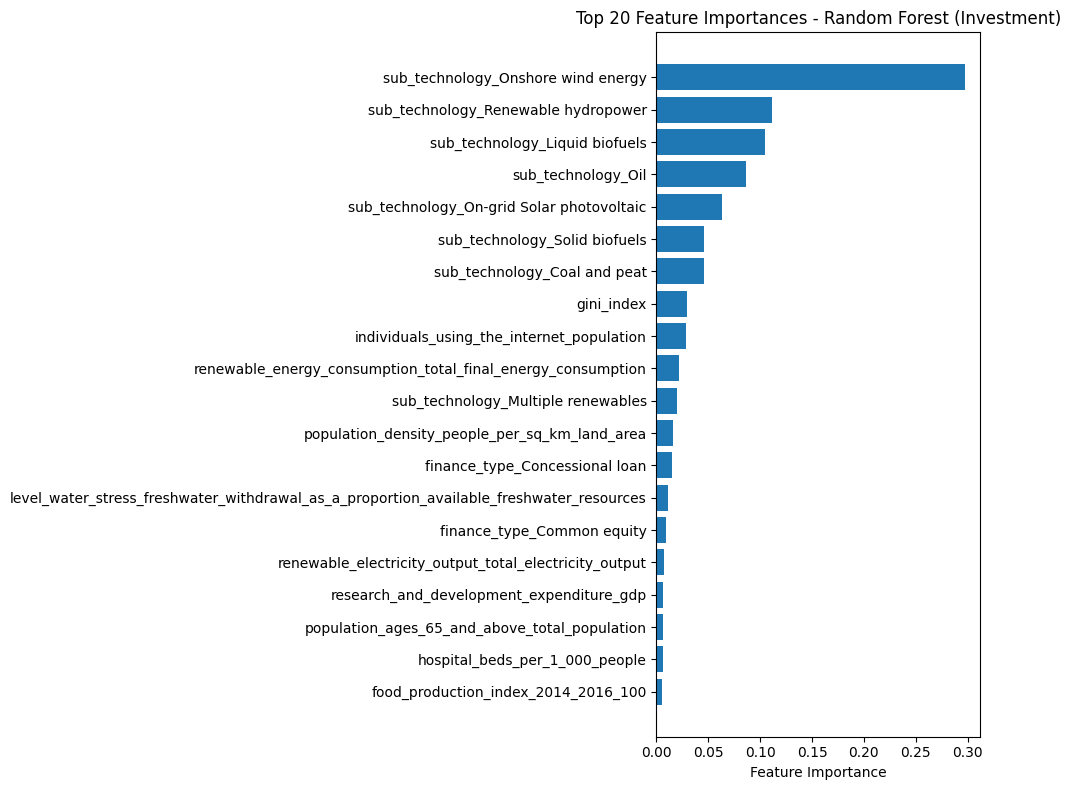

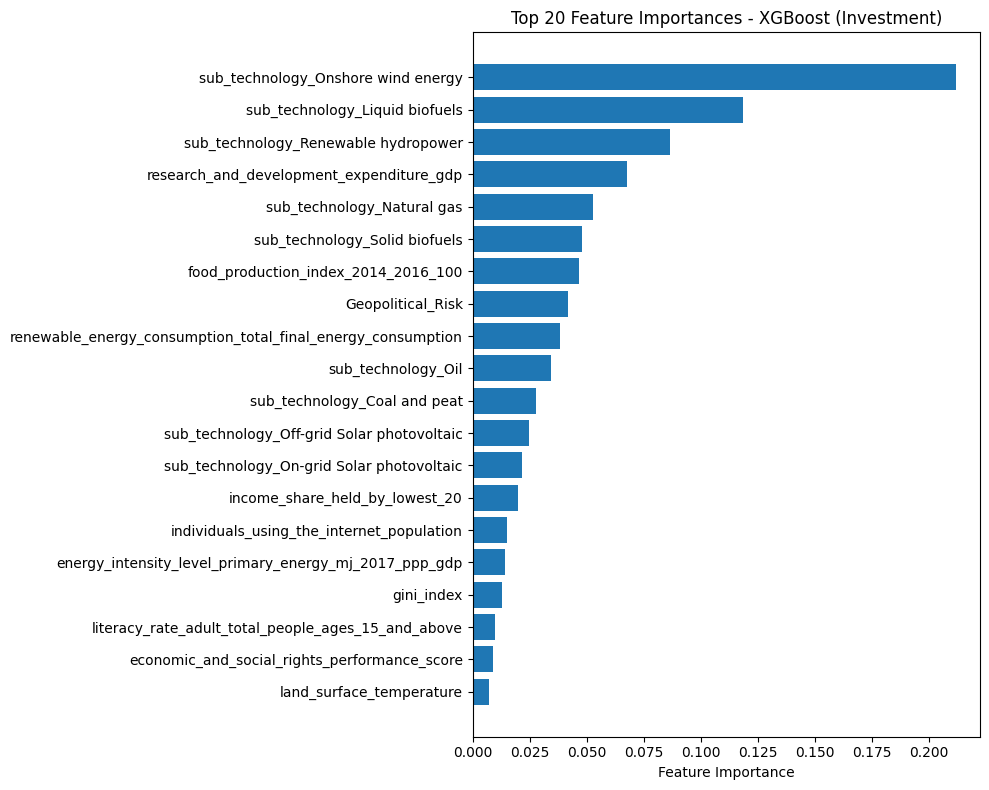

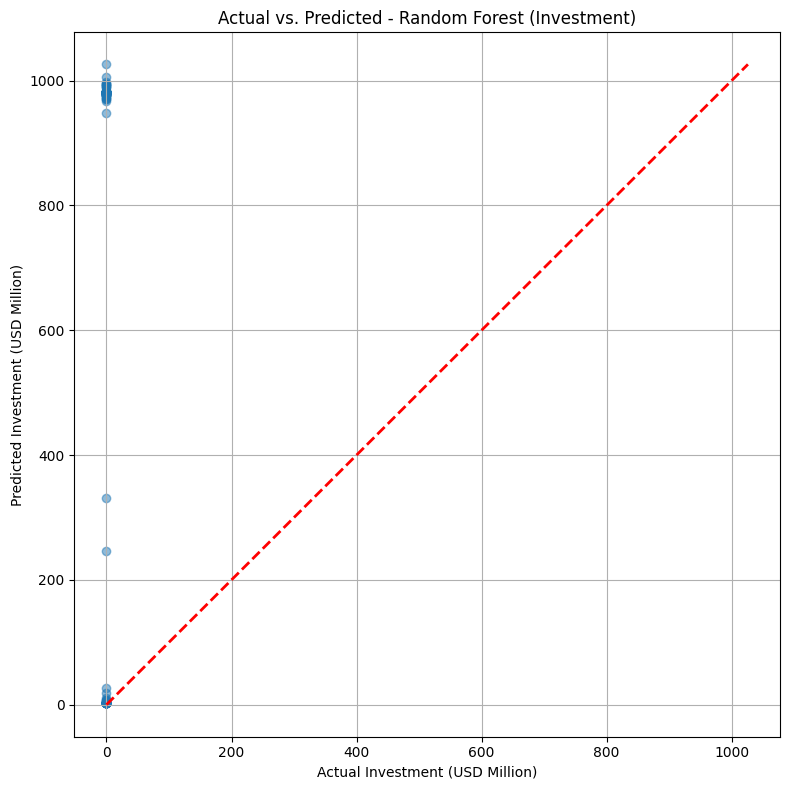

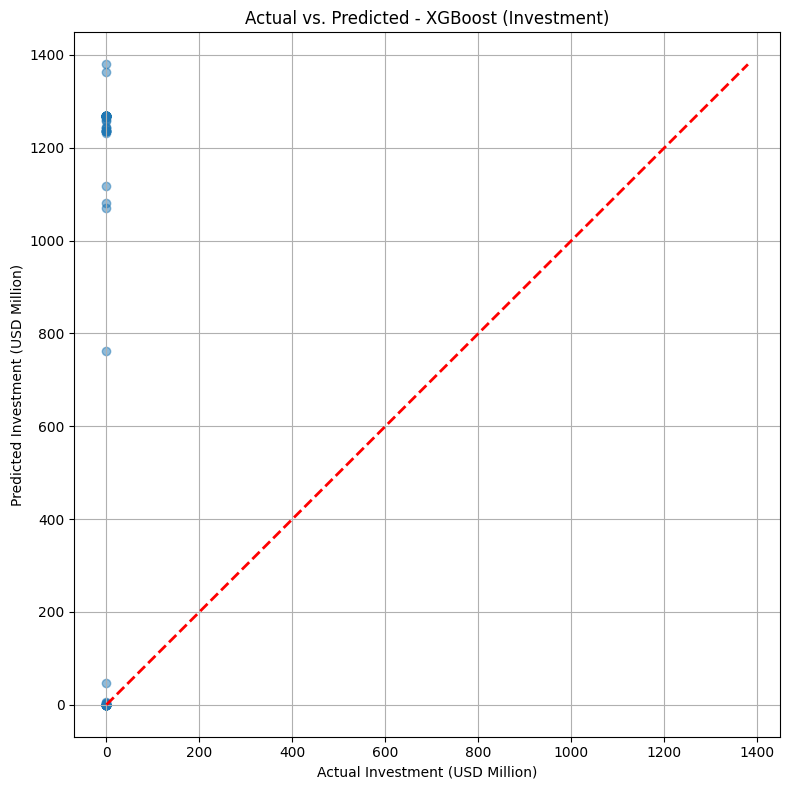

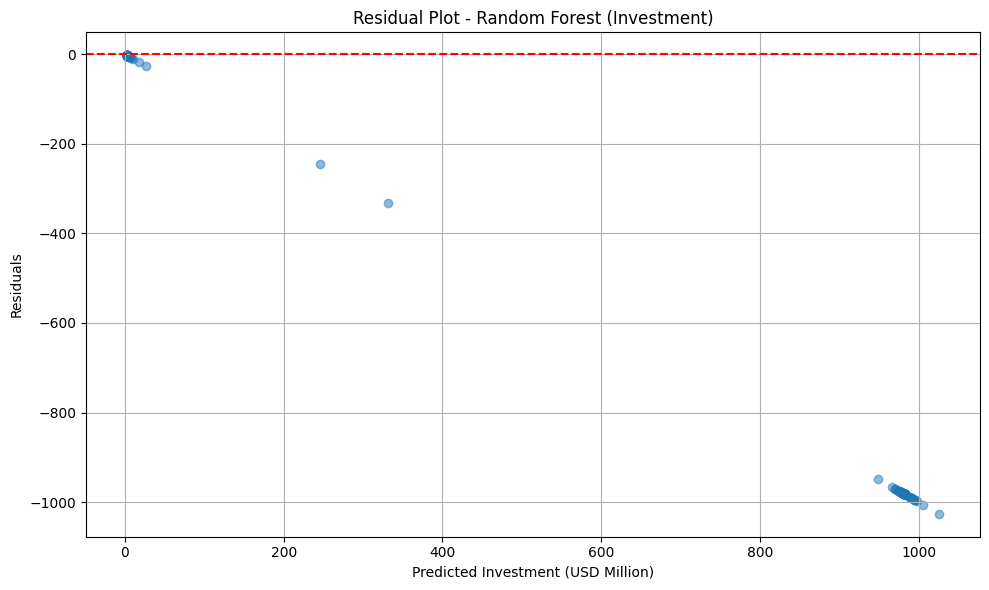

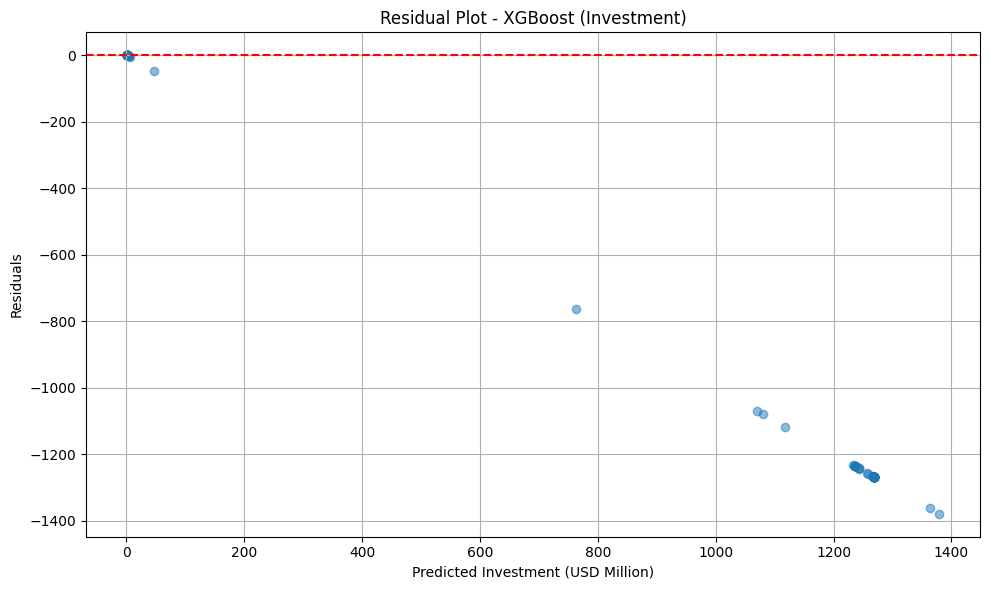


--- Analysis Complete ---


In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.panel import PooledOLS, RandomEffects, PanelOLS
from linearmodels.panel.results import compare # Import compare for neat display
# from linearmodels.panel.diagnostics import cd_test # Removed this line
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
import io
import traceback
from scipy import stats # For chi-squared test (Hausman)

# --- Check if running in Colab and import files module ---
try:
    import google.colab
    IN_COLAB = True
    from google.colab import files
    print("Running in Google Colab")
except:
    IN_COLAB = False
    print("Not running in Google Colab")


warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# --- 1. Data Loading ---
print("--- Loading Data ---")
try:
    # --- Corrected ESG Data Loading and Processing ---
    print("\n--- Formatting ESG Data ---")
    with open("ESG_indicators_wide_by_year.csv", 'r') as f:
        header_line = f.readline().strip()
        try:
            quote_start_index = header_line.find('"') + 1
            quote_end_index = header_line.rfind('"')
            header_string = header_line[quote_start_index:quote_end_index]
            correct_headers = [h.strip() for h in header_string.split('\t')]
            correct_headers = ['Country'] + correct_headers[1:]
            print("Extracted ESG Headers (sample):", correct_headers[:10], "...")
        except Exception as e:
             print(f"Error parsing ESG header: {e}. Falling back to standard read.")
             correct_headers = None

        try:
            esg_data_str = f.read()
            esg_wide_df_raw = pd.read_csv(io.StringIO(esg_data_str), sep=',', quotechar='"', header=None)
            print(f"Read ESG data content shape: {esg_wide_df_raw.shape}")

            if esg_wide_df_raw.shape[1] == 2:
                 processed_data = []
                 for index, row in esg_wide_df_raw.iterrows():
                      country_raw = row[0]
                      data_string = row[1]
                      if isinstance(data_string, str):
                          split_values = [val.strip() for val in data_string.split('\t')]
                          country_actual = split_values[0]
                          processed_row = [country_actual] + split_values[1:]
                          processed_data.append(processed_row)
                      else:
                          print(f"Warning: Skipping row {index} in ESG data due to unexpected format: {row}")

                 if correct_headers and len(processed_data) > 0:
                     if len(correct_headers) == len(processed_data[0]):
                          esg_wide_df = pd.DataFrame(processed_data, columns=correct_headers)
                          print("Successfully processed ESG data from raw read.")
                     else:
                         print(f"Warning: Header length ({len(correct_headers)}) != data row length ({len(processed_data[0])}). Using generic headers.")
                         esg_wide_df = pd.DataFrame(processed_data)
                         num_cols_data = esg_wide_df.shape[1]
                         esg_wide_df.columns = ['Country'] + [f'col_{i}' for i in range(1,num_cols_data)]
                         correct_headers = esg_wide_df.columns.tolist()
                 else:
                      raise ValueError("Could not process ESG data rows or headers.")

            else:
                print("Warning: ESG read resulted in > 2 columns. Attempting standard processing.")
                esg_wide_df = pd.read_csv(io.StringIO(header_line + '\n' + esg_data_str), sep=',', quotechar='"')
                esg_wide_df.columns = [col.strip().replace('"', '') for col in esg_wide_df.columns]
                if '\t' in esg_wide_df.columns[1]:
                    print("Detected nested headers in standard read, attempting correction...")
                    first_col_name = esg_wide_df.columns[0]
                    nested_headers = esg_wide_df.columns[1].split('\t')
                    corrected_headers_std = [first_col_name] + nested_headers[1:]
                    esg_wide_df.columns = corrected_headers_std
                    print("Corrected headers based on second column content.")
                correct_headers = esg_wide_df.columns.tolist()

        except Exception as e:
            print(f"Error during detailed ESG processing: {e}. Falling back to simpler load.")
            traceback.print_exc()
            esg_wide_df = pd.read_csv("ESG_indicators_wide_by_year.csv")
            esg_wide_df.columns = esg_wide_df.columns.str.strip().str.replace('"', '')
            correct_headers = None

    # --- Proceed with Melting ---
    esg_wide_df.columns = esg_wide_df.columns.str.strip()
    id_col = 'Country'
    value_vars = [col for col in esg_wide_df.columns if col != id_col]

    for col in value_vars:
         esg_wide_df[col] = pd.to_numeric(esg_wide_df[col], errors='coerce')

    print("ESG Data types after numeric conversion:")
    print(esg_wide_df.info(verbose=False))

    esg_long = pd.melt(esg_wide_df, id_vars=[id_col], value_vars=value_vars,
                       var_name='Indicator_Year', value_name='Value')

    try:
        esg_long['Year'] = esg_long['Indicator_Year'].str.extract(r'(\d{4})$', expand=False)
        esg_long['Indicator'] = esg_long['Indicator_Year'].str.replace(r'_\d{4}$', '', regex=True)
        needs_rsplit = esg_long['Year'].isnull()
        if needs_rsplit.any():
             print("Using rsplit fallback for some Indicator_Year entries...")
             split_data_fallback = esg_long.loc[needs_rsplit, 'Indicator_Year'].str.rsplit('_', n=1, expand=True)
             if split_data_fallback.shape[1] == 2:
                 esg_long.loc[needs_rsplit, 'Indicator'] = split_data_fallback[0]
                 esg_long.loc[needs_rsplit, 'Year'] = split_data_fallback[1]
             else:
                 print("rsplit fallback also failed.")
    except Exception as e:
         print(f"Error splitting Indicator_Year: {e}. Assigning NaN to Year.")
         esg_long['Indicator'] = esg_long['Indicator_Year']
         esg_long['Year'] = np.nan

    esg_long['Year'] = pd.to_numeric(esg_long['Year'], errors='coerce')
    esg_long.dropna(subset=['Year', 'Indicator'], inplace=True)
    esg_long['Year'] = esg_long['Year'].astype(int)

    esg_long.drop('Indicator_Year', axis=1, inplace=True)
    duplicates = esg_long.duplicated(subset=[id_col, 'Year', 'Indicator'], keep=False)
    if duplicates.any(): print(f"Warning: Found {duplicates.sum()} duplicate entries. Aggregating using mean.")

    try:
        esg_panel = esg_long.pivot_table(index=[id_col, 'Year'], columns='Indicator', values='Value', aggfunc='mean').reset_index()
    except Exception as pivot_e: print(f"Error during pivoting: {pivot_e}"); exit()

    esg_panel[id_col] = esg_panel[id_col].str.strip()

    processed_esg_filename = "ESG_panel_processed.csv"
    esg_panel.to_csv(processed_esg_filename, index=False)
    print(f"Processed ESG panel data saved to {processed_esg_filename}")
    if IN_COLAB:
        try:
            files.download(processed_esg_filename)
            print(f"Offering {processed_esg_filename} for download in Colab.")
        except Exception as e:
            print(f"Colab download trigger failed: {e}")

    print("Processed ESG Panel Head:")
    print(esg_panel.head())
    print("Processed ESG Panel Info:")
    print(esg_panel.info(verbose=False))

    gpr_df = pd.read_csv("Geopolitical_risk_Panel.csv")
    investment_df = pd.read_csv("PANEL_IRENA_RE_Investment_Processed_VIF_Reduced.csv")
    print("Other data loaded successfully.")
except FileNotFoundError as e: print(f"Error loading file: {e}"); exit()
except Exception as e: print(f"Unexpected error loading/formatting: {e}"); traceback.print_exc(); exit()


# --- 3. Data Merging ---
print("\n--- Merging Data ---")
gpr_df.columns = gpr_df.columns.str.strip(); gpr_df['Country'] = gpr_df['Country'].str.strip(); gpr_df['Year'] = pd.to_numeric(gpr_df['Year'], errors='coerce'); gpr_df.dropna(subset=['Year'], inplace=True); gpr_df['Year'] = gpr_df['Year'].astype(int)
investment_df.columns = investment_df.columns.str.strip().str.replace('癤\ufeff', '', regex=False); investment_df.rename(columns={'癤?Country': 'Country'}, inplace=True); investment_df['Country'] = investment_df['Country'].str.strip(); investment_df['Year'] = pd.to_numeric(investment_df['Year'], errors='coerce'); investment_df.dropna(subset=['Year'], inplace=True); investment_df['Year'] = investment_df['Year'].astype(int)

merged_df = pd.merge(esg_panel, gpr_df, on=['Country', 'Year'], how='inner')
print(f"Shape after merging ESG and GPR: {merged_df.shape}")
if merged_df.empty: print("Warning: Merging ESG and GPR resulted in empty DataFrame.")

investment_cols_to_keep = ['Country', 'Year', 'amount_usd_million'] + [col for col in investment_df.columns if 'sub_technology' in col or 'finance_type' in col]
investment_cols_to_keep = list(dict.fromkeys(investment_cols_to_keep))
investment_subset = investment_df[investment_cols_to_keep]
final_df = pd.merge(merged_df, investment_subset, on=['Country', 'Year'], how='left')
print(f"Shape after merging with Investment data: {final_df.shape}")

# --- 4. Revised Data Imputation ---
print("\n--- Performing Improved Imputation ---")
investment_related_cols = [col for col in final_df.columns if 'sub_technology' in col or 'finance_type' in col or 'amount_usd_million' in col]
other_numeric_cols = [col for col in final_df.select_dtypes(include=np.number).columns if col not in investment_related_cols and col != 'Year']
print(f"Imputing {len(investment_related_cols)} investment cols with 0...")
final_df[investment_related_cols] = final_df[investment_related_cols].fillna(0)
target = 'amount_usd_million'
print(f"NaNs in '{target}': {final_df[target].isnull().sum()}")
print(f"Applying grouped linear interpolation to {len(other_numeric_cols)} other cols...")
final_df.sort_values(by=['Country', 'Year'], inplace=True)
final_df[other_numeric_cols] = final_df.groupby('Country')[other_numeric_cols].transform(lambda group: group.interpolate(method='linear', limit_direction='both', limit_area='inside'))
nan_counts_after_interp = final_df[other_numeric_cols].isnull().sum()
cols_needing_further_fill = nan_counts_after_interp[nan_counts_after_interp > 0].index.tolist()
if cols_needing_further_fill:
    print(f"Applying grouped median fill for remaining {len(cols_needing_further_fill)} cols...")
    grouped_medians = final_df.groupby('Country')[cols_needing_further_fill].transform('median')
    final_df[cols_needing_further_fill] = final_df[cols_needing_further_fill].fillna(grouped_medians)
nan_counts_after_median = final_df[cols_needing_further_fill].isnull().sum()
cols_still_needing_fill = nan_counts_after_median[nan_counts_after_median > 0].index.tolist()
if cols_still_needing_fill:
    print(f"Applying global median fill for {len(cols_still_needing_fill)} remaining cols...")
    global_medians = final_df[cols_still_needing_fill].median()
    final_df[cols_still_needing_fill] = final_df[cols_still_needing_fill].fillna(global_medians)
all_numeric_cols = other_numeric_cols + investment_related_cols
nan_final_check = final_df[all_numeric_cols].isnull().sum().sum()
if nan_final_check == 0: print("\nImputation complete.")
else: print(f"\nWarning: {nan_final_check} NaNs remain."); print(final_df.isnull().sum()[final_df.isnull().sum() > 0])

# --- 5. Multicollinearity Check (VIF) ---
print("\n--- Calculating VIF ---")
if target not in final_df.columns or not pd.api.types.is_numeric_dtype(final_df[target]): print(f"Error: Target '{target}' missing/non-numeric."); exit()
numeric_cols_vif = final_df.select_dtypes(include=np.number).columns.tolist()
if 'Year' in numeric_cols_vif: numeric_cols_vif.remove('Year')
potential_predictors = [col for col in numeric_cols_vif if col != target]
print("Checking for constant/low variance features...")
non_constant_predictors = []
for col in potential_predictors:
     try:
        nunique = final_df[col].nunique(dropna=False); variance = final_df[col].var(ddof=0)
        if nunique > 1 and variance > 1e-10 : non_constant_predictors.append(col)
        else: print(f"  Dropping '{col}' (Unique: {nunique}, Variance: {variance:.2e})")
     except TypeError: print(f"  Skipping non-numeric '{col}'")
X = final_df[non_constant_predictors]
if X.empty: print("Error: No predictors left after variance check."); exit()
if X.isnull().values.any() or np.isinf(X.values).any(): print("Error: NaNs/Infs in predictors before VIF."); exit()
X_with_const = sm.add_constant(X, has_constant='add')
if X_with_const.isnull().values.any() or np.isinf(X_with_const.values).any(): print("Error: NaNs/Infs after adding constant."); exit()

vif_threshold = 10; max_vif = float('inf'); features_after_vif = list(X.columns)
while len(features_after_vif) > 1:
    X_vif_subset = final_df[features_after_vif]
    if X_vif_subset.isnull().values.any() or np.isinf(X_vif_subset.values).any(): print("Error: NaNs/Infs in VIF subset."); break
    X_vif_calc = sm.add_constant(X_vif_subset, has_constant='add')
    try:
         vif_data = pd.DataFrame({'feature': X_vif_calc.columns})
         vif_data['VIF'] = [variance_inflation_factor(X_vif_calc.values, i) for i in range(X_vif_calc.shape[1])]
         vif_data = vif_data[vif_data['feature'] != 'const']
    except Exception as e: print(f"VIF Error: {e}"); break
    if vif_data.empty: print("VIF data empty. Breaking."); break
    inf_vif_features = vif_data[vif_data['VIF'] == np.inf]['feature'].tolist()
    if inf_vif_features:
        feature_to_remove = inf_vif_features[0]
        print(f"Removing '{feature_to_remove}' (infinite VIF).")
        if feature_to_remove in features_after_vif: features_after_vif.remove(feature_to_remove); continue
    max_vif = vif_data['VIF'].max()
    if max_vif > vif_threshold:
        max_vif_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'feature']
        print(f"Removing '{max_vif_feature}' (VIF: {max_vif:.2f})")
        if max_vif_feature in features_after_vif: features_after_vif.remove(max_vif_feature)
        else: break
    else: print(f"All VIFs below {vif_threshold}."); break
print(f"\nFeatures remaining after VIF reduction: {len(features_after_vif)}")
cols_to_keep_final = ['Country', 'Year', target] + features_after_vif
final_df_vif = final_df[cols_to_keep_final].copy()
if final_df_vif.drop(columns=['Country']).isnull().values.any(): print("WARNING: NaNs detected in final DF after VIF!"); exit()

# --- 6. Panel Data Regression & Diagnostics ---
print("\n--- Running Panel Data Regressions & Diagnostics (Target: amount_usd_million) ---")
models_fitted = {}
hausman_pvalue = np.nan

try:
    panel_data_indexed = final_df_vif.set_index(['Country', 'Year'])
    y = panel_data_indexed[target]
    X_panel = panel_data_indexed[features_after_vif]
    X_panel_const = sm.add_constant(X_panel, has_constant='add')

    if y.isnull().any() or X_panel_const.isnull().values.any() or np.isinf(y.values).any() or np.isinf(X_panel_const.values).any():
        print("ERROR: NaNs/Infs present before panel fitting."); exit()

    # --- Fit Models ---
    print("\n--- Pooled OLS ---")
    models_fitted['Pooled'] = PooledOLS(y, X_panel_const).fit(cov_type='clustered', cluster_entity=True)
    print(models_fitted['Pooled'])

    print("\n--- Fixed Effects (Entity) ---")
    models_fitted['FE_Entity'] = PanelOLS(y, X_panel, entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
    print(models_fitted['FE_Entity'])

    print("\n--- Fixed Effects (Entity and Time) ---")
    models_fitted['FE_Both'] = PanelOLS(y, X_panel, entity_effects=True, time_effects=True).fit(cov_type='clustered', cluster_entity=True)
    print(models_fitted['FE_Both'])

    print("\n--- Random Effects ---")
    models_fitted['RE'] = RandomEffects(y, X_panel_const).fit(cov_type='clustered', cluster_entity=True)
    print(models_fitted['RE'])

    # --- Model Selection Tests ---
    print("\n--- Panel Model Selection Tests ---")

    # 1. F-test for Poolability (Checks if FE model explains more than Pooled)
    print("\n1. F-test for Poolability (from FE_Both model):")
    try:
        if hasattr(models_fitted['FE_Both'], 'f_pooled') and hasattr(models_fitted['FE_Both'].f_pooled, 'pval'):
            f_pooled_stat = models_fitted['FE_Both'].f_pooled.stat
            f_pooled_pvalue = models_fitted['FE_Both'].f_pooled.pval
            print(f"   F-pooled Test Statistic: {f_pooled_stat:.4f}")
            print(f"   F-pooled Test p-value: {f_pooled_pvalue:.4f}")
            if f_pooled_pvalue < 0.05: print("   Interpretation: Reject Pooled OLS. Fixed effects are jointly significant.")
            else: print("   Interpretation: Cannot reject Pooled OLS based on F-test.")
        else: print("   F-test for Poolability attribute not found.")
    except Exception as e: print(f"   Error retrieving F-test: {e}")


    # 2. Hausman Test (Checks FE vs RE consistency)
    print("\n2. Hausman Test (FE_Entity vs RE):")
    try:
        fe_coef = models_fitted['FE_Entity'].params
        re_coef = models_fitted['RE'].params.drop('const')
        common_coef_idx = fe_coef.index.intersection(re_coef.index)
        fe_coef_common = fe_coef[common_coef_idx]
        re_coef_common = re_coef[common_coef_idx]
        fe_cov = models_fitted['FE_Entity'].cov.loc[common_coef_idx, common_coef_idx]
        re_cov = models_fitted['RE'].cov.loc[common_coef_idx, common_coef_idx]
        coef_diff = fe_coef_common - re_coef_common
        cov_diff = fe_cov - re_cov
        inv_cov_diff = np.linalg.pinv(cov_diff)
        hausman_stat = coef_diff.T @ inv_cov_diff @ coef_diff
        degrees_freedom = len(coef_diff)
        hausman_pvalue = stats.chi2.sf(hausman_stat, degrees_freedom)
        print(f"   Hausman Test Statistic (Chi2): {hausman_stat:.4f}")
        print(f"   Degrees of Freedom: {degrees_freedom}")
        print(f"   Hausman Test p-value: {hausman_pvalue:.4f}")
        if hausman_pvalue < 0.05: print("   Interpretation: Reject H0. Fixed Effects model is preferred.")
        else: print("   Interpretation: Fail to reject H0. Random Effects might be consistent/efficient.")
    except Exception as e: print(f"   Could not perform Hausman test: {e}")


    # Note: Breusch-Pagan test primarily compares RE vs Pooled. Since the F-test likely rejects Pooled,
    #       the choice between FE and RE hinges more directly on the Hausman test.

    # (No CD test implemented due to import error)
    print("\n(Skipping CD test due to import issues)")

except Exception as e:
     print(f"An error occurred during panel regression section: {e}")
     traceback.print_exc()

# --- 7. Machine Learning Models ---
print("\n--- Running Machine Learning Models (Target: amount_usd_million) ---")
X_ml = final_df_vif[features_after_vif]
y_ml = final_df_vif[target]
if X_ml.isnull().values.any() or y_ml.isnull().any() or np.isinf(X_ml.values).any() or np.isinf(y_ml.values).any(): print("ERROR: NaNs/Infs before ML split."); exit()
print("\n--- Performing Time-Based Train/Test Split ---")
years = sorted(final_df_vif['Year'].unique()); n_test_years = 2
if len(years) <= n_test_years: n_test_years = 1
if len(years) <= 1: print("Error: Only one year data."); exit()
test_years = years[-n_test_years:]; train_years = years[:-n_test_years]; test_year_cutoff = min(test_years)
print(f"Training Years: {min(train_years)}-{max(train_years)}; Testing Years: {min(test_years)}-{max(test_years)}")
train_idx = final_df_vif['Year'] < test_year_cutoff; test_idx = final_df_vif['Year'] >= test_year_cutoff
X_train, X_test, y_train, y_test = X_ml[train_idx], X_ml[test_idx], y_ml[train_idx], y_ml[test_idx]
print(f"Train shape: X={X_train.shape}, y={y_train.shape}; Test shape: X={X_test.shape}, y={y_test.shape}")
if X_train.empty or y_train.empty or X_test.empty or y_test.empty: print("Error: Empty train/test set."); exit()

print("\n--- Training Random Forest ---")
y_pred_rf = np.full_like(y_test, fill_value=np.nan)
try:
    rf_model = RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1, max_depth=15, min_samples_split=5, min_samples_leaf=3, oob_score=True, max_features=0.5)
    rf_model.fit(X_train, y_train)
    print(f"RF OOB Score: {rf_model.oob_score_:.4f}")
    y_pred_rf = rf_model.predict(X_test)
except Exception as e: print(f"Error training RF: {e}")

print("\n--- Training XGBoost ---")
y_pred_xgb = np.full_like(y_test, fill_value=np.nan)
try:
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.03, max_depth=5, subsample=0.8, colsample_bytree=0.7, random_state=42, n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
except Exception as e: print(f"Error training XGBoost: {e}")

# --- 8. Model Evaluation ---
print("\n--- Evaluating Machine Learning Models (Target: amount_usd_million) ---")
results = [];
def evaluate_model(y_true, y_pred, model_name): # Define if not already done
    valid_idx = ~np.isnan(y_pred) & ~np.isnan(y_true)
    if not np.any(valid_idx): print(f"No valid preds for {model_name}"); return {'Model': model_name, 'R2': np.nan, 'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan}
    y_true_eval, y_pred_eval = y_true[valid_idx], y_pred[valid_idx]
    if len(y_true_eval) == 0: print(f"No valid pairs for {model_name}"); return {'Model': model_name, 'R2': np.nan, 'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan}
    r2 = r2_score(y_true_eval, y_pred_eval); mae = mean_absolute_error(y_true_eval, y_pred_eval); mse = mean_squared_error(y_true_eval, y_pred_eval); rmse = np.sqrt(mse)
    print(f"--- {model_name} ---\nR-squared: {r2:.4f}\nMAE:       {mae:.4f}\nMSE:       {mse:.4f}\nRMSE:      {rmse:.4f}")
    return {'Model': model_name, 'R2': r2, 'MAE': mae, 'MSE': mse, 'RMSE': rmse}
results.append(evaluate_model(y_test, y_pred_rf, "Random Forest")); results.append(evaluate_model(y_test, y_pred_xgb, "XGBoost"))
results_df = pd.DataFrame(results); print("\n--- Model Performance Summary ---"); print(results_df)

# --- 9. Visualization ---
print("\n--- Generating Visualizations (Target: amount_usd_million) ---")
def plot_feature_importance(model, features, model_name):
    if hasattr(model, 'feature_importances_'):
        try:
             importances = model.feature_importances_
             if len(features) == len(importances):
                 indices = np.argsort(importances)[-20:]
                 plt.figure(figsize=(10, max(8, len(indices)*0.4)))
                 plt.barh(range(len(indices)), importances[indices], align='center'); plt.yticks(range(len(indices)), [features[i] for i in indices])
                 plt.xlabel('Feature Importance'); plt.title(f'Top 20 Feature Importances - {model_name}'); plt.tight_layout(); plt.show()
             else: print(f"Plot skip: Length mismatch feats/importances {model_name}.")
        except Exception as plot_err: print(f"Plotting FE importance error: {plot_err}")
    else: print(f"{model_name} no feature_importances_")
def plot_actual_vs_predicted(y_true, y_pred, model_name):
    valid_idx = ~np.isnan(y_pred) & ~np.isnan(y_true);
    if not np.any(valid_idx): print(f"Plot skip: invalid preds/true for {model_name}."); return
    y_true_plot, y_pred_plot = y_true[valid_idx], y_pred[valid_idx]
    if len(y_true_plot) == 0: print(f"Plot skip: No valid pairs for {model_name}."); return
    plt.figure(figsize=(8, 8)); plt.scatter(y_true_plot, y_pred_plot, alpha=0.5)
    min_val = min(y_true_plot.min(), y_pred_plot.min()); max_val = max(y_true_plot.max(), y_pred_plot.max())
    plt.plot([min_val, max_val], [min_val, max_val], '--r', linewidth=2); plt.xlabel('Actual Investment (USD Million)'); plt.ylabel('Predicted Investment (USD Million)')
    plt.title(f'Actual vs. Predicted - {model_name}'); plt.grid(True); plt.tight_layout(); plt.show()
def plot_residuals(y_true, y_pred, model_name):
    valid_idx = ~np.isnan(y_pred) & ~np.isnan(y_true);
    if not np.any(valid_idx) : print(f"Plot skip: invalid preds/true for {model_name}."); return
    y_true_plot, y_pred_plot = y_true[valid_idx], y_pred[valid_idx];
    if len(y_true_plot) == 0: print(f"Plot skip: No valid pairs for {model_name}."); return
    residuals = y_true_plot - y_pred_plot
    plt.figure(figsize=(10, 6)); plt.scatter(y_pred_plot, residuals, alpha=0.5); plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Investment (USD Million)'); plt.ylabel('Residuals'); plt.title(f'Residual Plot - {model_name}')
    plt.grid(True); plt.tight_layout(); plt.show()

if 'rf_model' in locals(): plot_feature_importance(rf_model, features_after_vif, "Random Forest (Investment)")
if 'xgb_model' in locals(): plot_feature_importance(xgb_model, features_after_vif, "XGBoost (Investment)")
if 'rf_model' in locals(): plot_actual_vs_predicted(y_test, y_pred_rf, "Random Forest (Investment)")
if 'xgb_model' in locals(): plot_actual_vs_predicted(y_test, y_pred_xgb, "XGBoost (Investment)")
if 'rf_model' in locals(): plot_residuals(y_test, y_pred_rf, "Random Forest (Investment)")
if 'xgb_model' in locals(): plot_residuals(y_test, y_pred_xgb, "XGBoost (Investment)")


print("\n--- Analysis Complete ---")

### Prepare and format data for Panel Data Regression

In [ ]:
import pandas as pd

# --- Configuration ---
# Define the input file paths
irena_file = 'IRENA_RE_Public_Investment_July2022(July2022).csv'
worldbank_file = 'WorldBank_ESG.csv'

# Define the output file path for the merged data
output_file = 'merged_irena_worldbank_investment_esg.csv'

# Define the common column name to merge on
merge_column = 'Country'

# --- Main Script ---
print("Starting the merge process...")

try:
    # Read the IRENA dataset into a pandas DataFrame
    print(f"Reading IRENA data from: {irena_file}")
    irena_df = pd.read_csv(irena_file)
    print(f" -> IRENA data loaded. Shape: {irena_df.shape}")
    # Optional: Print column names to verify 'Country' exists
    # print("IRENA Columns:", irena_df.columns.tolist())

    # Read the World Bank dataset into a pandas DataFrame
    print(f"Reading World Bank data from: {worldbank_file}")
    worldbank_df = pd.read_csv(worldbank_file)
    print(f" -> World Bank data loaded. Shape: {worldbank_df.shape}")
    # Optional: Print column names to verify 'Country' exists
    # print("World Bank Columns:", worldbank_df.columns.tolist())

    # --- Data Cleaning/Preparation (Optional but Recommended) ---
    # Check if the merge column exists in both dataframes
    if merge_column not in irena_df.columns:
        raise ValueError(f"Merge column '{merge_column}' not found in {irena_file}")
    if merge_column not in worldbank_df.columns:
        raise ValueError(f"Merge column '{merge_column}' not found in {worldbank_file}")

    # Optional: Standardize the 'Country' column (e.g., strip whitespace)
    # irena_df[merge_column] = irena_df[merge_column].str.strip()
    # worldbank_df[merge_column] = worldbank_df[merge_column].str.strip()
    # You might need more complex cleaning if country names differ significantly
    # (e.g., 'United States' vs 'United States of America')

    # --- Perform the Merge ---
    print(f"\nMerging the datasets on the '{merge_column}' column...")

    # Use pd.merge(). 'inner' join keeps only countries present in BOTH datasets.
    # Use how='left' to keep all IRENA countries and add World Bank data where available.
    # Use how='outer' to keep all countries from both datasets.
    merged_df = pd.merge(
        left=irena_df,
        right=worldbank_df,
        on=merge_column,  # Column(s) to join on
        how='inner'       # Type of merge ('inner', 'left', 'right', 'outer')
    )

    print(f" -> Merge complete. Shape of merged data: {merged_df.shape}")
    # Display how many unique countries were matched
    print(f" -> Number of unique countries matched: {merged_df[merge_column].nunique()}")

    # --- Save the Merged Data ---
    print(f"\nSaving the merged data to: {output_file}")
    # index=False prevents pandas from writing the DataFrame index as a column
    merged_df.to_csv(output_file, index=False, encoding='utf-8') # Specify encoding for broader compatibility
    print(" -> Successfully saved merged data.")

    print("\nMerge process finished.")

except FileNotFoundError as e:
    print(f"\nError: File not found - {e}")
    print("Please ensure both CSV files are in the same directory as the script,")
    print("or provide the full correct path to the files.")
except ValueError as e:
    print(f"\nError: {e}")
    print("Please check the column names in your CSV files.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

Starting the merge process...
Reading IRENA data from: IRENA_RE_Public_Investment_July2022(July2022).csv

Error: 'utf-8' codec can't decode byte 0xe9 in position 2122: invalid continuation byte
Please check the column names in your CSV files.


In [ ]:
import pandas as pd

# --- Configuration ---
# Define the input file paths
irena_file = '/content/IRENA_RE_Public_Investment_July2022(July2022).csv'
worldbank_file = '/content/WorldBank_ESG.csv'

# Define the output file path for the merged data




# Define the output file path for the merged data
output_file = 'merged_irena_worldbank_investment_esg.csv' # This will be saved in the /content/ directory

# Define the common column name to merge on
merge_column = 'Country'

# --- Main Script ---
print("Starting the merge process...")

try:
    # Read the IRENA dataset into a pandas DataFrame
    # *** Try reading with 'latin-1' encoding ***
    print(f"Reading IRENA data from: {irena_file}")
    try:
        irena_df = pd.read_csv(irena_file, encoding='latin1')
    except UnicodeDecodeError:
        print(" -> Failed with 'latin1', trying 'cp1252'...")
        # If latin1 fails, try cp1252 which is common on Windows
        irena_df = pd.read_csv(irena_file, encoding='cp1252')
    except Exception as e:
        print(f" -> Failed to read IRENA file even with alternate encodings: {e}")
        raise # Re-raise the exception to stop execution

    print(f" -> IRENA data loaded successfully. Shape: {irena_df.shape}")
    # Optional: Print column names to verify 'Country' exists
    # print("IRENA Columns:", irena_df.columns.tolist())

    # Read the World Bank dataset into a pandas DataFrame
    # Assume UTF-8 for World Bank, but add encoding if it also causes issues
    print(f"Reading World Bank data from: {worldbank_file}")
    try:
        worldbank_df = pd.read_csv(worldbank_file) # Try default first (often utf-8)
    except UnicodeDecodeError:
        print(f" -> World Bank file is not UTF-8. Trying 'latin1'...")
        try:
             worldbank_df = pd.read_csv(worldbank_file, encoding='latin1')
        except UnicodeDecodeError:
             print(" -> Failed with 'latin1', trying 'cp1252'...")
             worldbank_df = pd.read_csv(worldbank_file, encoding='cp1252')
        except Exception as e:
             print(f" -> Failed to read World Bank file even with alternate encodings: {e}")
             raise
    except Exception as e:
        print(f" -> Failed to read World Bank file: {e}")
        raise

    print(f" -> World Bank data loaded. Shape: {worldbank_df.shape}")
    # Optional: Print column names to verify 'Country' exists
    # print("World Bank Columns:", worldbank_df.columns.tolist())

    # --- Data Cleaning/Preparation (Optional but Recommended) ---
    # Check if the merge column exists in both dataframes
    if merge_column not in irena_df.columns:
        raise ValueError(f"Merge column '{merge_column}' not found in {irena_file}")
    if merge_column not in worldbank_df.columns:
        raise ValueError(f"Merge column '{merge_column}' not found in {worldbank_file}")

    # Optional: Standardize the 'Country' column (e.g., strip whitespace)
    # It's good practice to strip whitespace as it can cause merge mismatches
    irena_df[merge_column] = irena_df[merge_column].str.strip()
    worldbank_df[merge_column] = worldbank_df[merge_column].str.strip()
    # You might need more complex cleaning if country names differ significantly
    # (e.g., 'United States' vs 'United States of America')

    # --- Perform the Merge ---
    print(f"\nMerging the datasets on the '{merge_column}' column...")

    # Use pd.merge(). 'inner' join keeps only countries present in BOTH datasets.
    merged_df = pd.merge(
        left=irena_df,
        right=worldbank_df,
        on=merge_column,
        how='inner' # Change to 'left', 'right', or 'outer' if needed
    )

    # --- Check if the merge resulted in any rows ---
    if merged_df.empty:
        print("\nWarning: The merge resulted in an empty DataFrame.")
        print("This could mean:")
        print(f"  - No common '{merge_column}' values were found between the two files after cleaning.")
        print(f"  - The '{merge_column}' values have formatting differences (e.g., 'USA' vs 'United States').")
        # Optional: Print unique country names from each df to help debug
        # print("\nUnique countries in IRENA data (first 50):", irena_df[merge_column].unique()[:50])
        # print("\nUnique countries in World Bank data (first 50):", worldbank_df[merge_column].unique()[:50])
    else:
        print(f" -> Merge complete. Shape of merged data: {merged_df.shape}")
        print(f" -> Number of unique countries matched: {merged_df[merge_column].nunique()}")

        # --- Save the Merged Data ---
        print(f"\nSaving the merged data to: {output_file}")
        # Save with UTF-8 encoding, which is generally preferred for output
        merged_df.to_csv(output_file, index=False, encoding='utf-8')
        print(" -> Successfully saved merged data.")

    print("\nMerge process finished.")

except FileNotFoundError as e:
    print(f"\nError: File not found - {e}")
    print("Please ensure both CSV files exist at the specified paths.")
except ValueError as e: # Catches errors from column name checks
    print(f"\nError: {e}")
    print("Please check the column names in your CSV files.")
except Exception as e: # Catches other errors like encoding issues during read or merge problems
    print(f"\nAn unexpected error occurred: {e}")

Starting the merge process...
Reading IRENA data from: /content/IRENA_RE_Public_Investment_July2022(July2022).csv
 -> IRENA data loaded successfully. Shape: (15707, 12)
Reading World Bank data from: /content/WorldBank_ESG.csv
 -> World Bank data loaded. Shape: (14555, 26)

Merging the datasets on the 'Country' column...
 -> Merge complete. Shape of merged data: (902481, 37)
 -> Number of unique countries matched: 155

Saving the merged data to: merged_irena_worldbank_investment_esg.csv
 -> Successfully saved merged data.

Merge process finished.


In [ ]:
import pandas as pd
import numpy as np
import warnings
import csv # Import csv module

# Suppress potential warnings (like DtypeWarning if columns have mixed types)
warnings.filterwarnings('ignore')

# Define the filename
# **** IMPORTANT: Replace this with the actual path to your CSV file ****
filename = "/content/merged_irena_worldbank_investment_esg.csv"

print(f"--- Exploring Dataset: {filename} ---")

load_successful = False
df_merged = pd.DataFrame() # Initialize an empty DataFrame

# --- Attempt 1: Basic read (likely failed based on error) ---
# This is commented out but kept for reference
# try:
#     df_merged = pd.read_csv(filename)
#     print("Attempt 1: Basic read successful.")
#     load_successful = True
# except Exception as e:
#     print(f"Attempt 1 (Basic read) failed: {e}")

# --- Attempt 2: Specify comma delimiter and try Python engine ---
if not load_successful:
    print("\nAttempting load with engine='python'...")
    try:
        df_merged = pd.read_csv(filename, sep=',', engine='python', quotechar='"', escapechar='\\')
        # Added quotechar and escapechar which might help with complex quoting
        print("Load successful with engine='python'.")
        load_successful = True
    except pd.errors.ParserError as pe:
        print(f"Load with engine='python' failed: {pe}")
        print("This often indicates issues like unquoted delimiters within fields or inconsistent column counts.")
        # Extract line number if possible from the error message
        try:
            line_num_str = str(pe).split('line ')[-1].split(',')[0]
            print(f"Check the structure of line {line_num_str} in the CSV file.")
        except:
            print("Could not extract problematic line number from error message.")
        load_successful = False
    except FileNotFoundError:
        print(f"ERROR: File not found at '{filename}'. Please check the path.")
        load_successful = False
    except Exception as e:
        print(f"An unexpected error occurred during engine='python' loading: {e}")
        load_successful = False


# --- Attempt 3: Try skipping bad lines (if Attempt 2 failed) ---
if not load_successful:
    print("\nAttempting load with engine='python' and skipping bad lines (on_bad_lines='skip')...")
    print("WARNING: This will skip rows with incorrect column counts. Data will be lost.")
    try:
        # Using on_bad_lines='skip' (standard for newer pandas)
        df_merged = pd.read_csv(filename, sep=',', engine='python', on_bad_lines='skip', quotechar='"', escapechar='\\')
        # For older pandas versions (uncomment if needed):
        # df_merged = pd.read_csv(filename, sep=',', engine='python', error_bad_lines=False, quotechar='"', escapechar='\\')
        print("Load partially successful by skipping bad lines.")
        if not df_merged.empty: # Check if loading actually returned data
             load_successful = True
        else:
             print("Warning: Skipping bad lines resulted in an empty DataFrame.")
             load_successful = False

    except pd.errors.ParserError as pe:
        print(f"Load skipping bad lines also failed: {pe}")
        load_successful = False
    except FileNotFoundError:
        print(f"ERROR: File not found at '{filename}'. Please check the path.")
        load_successful = False
    except Exception as e:
        print(f"An unexpected error occurred during loading while skipping bad lines: {e}")
        load_successful = False

# --- Proceed with Exploration only if loading was successful ---
if load_successful and not df_merged.empty:
    print("\nDataset loaded successfully (potentially with skipped rows).")

    # 1. Display Shape
    print("\n--- Data Shape ---")
    print(f"Rows: {df_merged.shape[0]}, Columns: {df_merged.shape[1]}")

    # 2. Display Column Names
    print("\n--- Column Names ---")
    # Truncate if too long for better display
    all_cols = df_merged.columns.tolist()
    if len(all_cols) > 50:
         print(all_cols[:25], "...", all_cols[-25:])
    else:
         print(all_cols)


    # 3. Display Data Types and Non-Null Counts
    print("\n--- Data Types and Non-Null Counts ---")
    from io import StringIO
    buffer = StringIO()
    # Increase max_cols if needed, or use display options
    # pd.options.display.max_info_columns = df_merged.shape[1] + 1
    df_merged.info(buf=buffer, max_cols=df_merged.shape[1]+1) # Ensure all columns are shown if many
    info_str = buffer.getvalue()
    print(info_str)

    # 4. Display Missing Value Counts
    print("\n--- Missing Value Counts ---")
    missing_values = df_merged.isnull().sum()
    missing_cols = missing_values[missing_values > 0].sort_values(ascending=False) # Sort for clarity
    if not missing_cols.empty:
        print(f"Total columns with missing values: {len(missing_cols)}")
        print(missing_cols)
    else:
        print("No missing values found.")

    # 5. Display Head
    print("\n--- First 5 Rows (Head) ---")
    print(df_merged.head())

    # 6. Display Tail
    print("\n--- Last 5 Rows (Tail) ---")
    print(df_merged.tail())

    # 7. Describe Numeric Columns
    print("\n--- Descriptive Statistics (Numeric Columns) ---")
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    numeric_desc = df_merged.describe(include=[np.number])
    if not numeric_desc.empty:
        print(numeric_desc)
    else:
        print("No numeric columns found to describe.")
    pd.reset_option('display.float_format') # Reset float formatting

    # 8. Describe Object/Categorical Columns
    print("\n--- Descriptive Statistics (Categorical/Object Columns) ---")
    try:
        object_desc = df_merged.describe(include=['object'])
        if not object_desc.empty:
            print(object_desc)
        else:
            print("No object/categorical columns found to describe.")
    except ValueError:
         print("No object/categorical columns found to describe.")

    # 9. Display Number of Unique Values per Column
    print("\n--- Unique Value Counts (Sample - Sorted) ---")
    unique_counts = df_merged.nunique().sort_values()
    print(unique_counts)


elif not load_successful:
    print("\nERROR: Could not load the dataset even after trying different methods.")
    print("Recommendations:")
    print("1. **Manually Inspect the CSV:** Open 'merged_irena_worldbank_investment_esg.csv' in a spreadsheet program (like Excel, Google Sheets, LibreOffice Calc) or a good text editor that can handle large files.")
    print("2. **Find the Problematic Line:** Go to the line number mentioned in the 'ParserError' message (e.g., line 2526 from your error).")
    print("3. **Look for Issues:**")
    print("   - **Extra Delimiters:** Are there more commas on that line than in the header or other lines? Check if commas exist inside text fields *without* being enclosed in quotes.")
    print("   - **Quoting Problems:** Are quotes opened but not closed, or vice-versa? Are quotes used inconsistently?")
    print("   - **Inconsistent Structure:** Does this line fundamentally have a different number of data points?")
    print("4. **Fix or Remove:** Either correct the problematic line(s) in the CSV file or remove them if they are corrupt/unnecessary.")
    print("5. **Re-run:** Try running this Python script again after fixing the CSV.")
    print("6. **Advanced Parsing:** If the issue is widespread, consider reading the file line-by-line using the `csv` module for more granular control over parsing.")

print("\n--- Exploration Complete ---")

--- Exploring Dataset: /content/merged_irena_worldbank_investment_esg.csv ---

Attempting load with engine='python'...
Load with engine='python' failed: ',' expected after '"'
This often indicates issues like unquoted delimiters within fields or inconsistent column counts.
Check the structure of line ' in the CSV file.

Attempting load with engine='python' and skipping bad lines (on_bad_lines='skip')...
Load partially successful by skipping bad lines.

Dataset loaded successfully (potentially with skipped rows).

--- Data Shape ---
Rows: 925839, Columns: 37

--- Column Names ---
['Country', 'Year', 'Project', 'Donor', 'Agency', 'Category', 'Technology', 'Sub_technology', 'Finance_Group', 'Finance_Type', ' Date', 'Amount_2020_USD_million', 'ESG_indicator', '2000_ESG_rating', '2001_ESG_rating', '2002_ESG_rating', '2003_ESG_rating', '2004_ESG_rating', '2005_ESG_rating', '2006_ESG_rating', '2007_ESG_rating', '2008_ESG_rating', '2009_ESG_rating', '2010_ESG_rating', '2011_ESG_rating', '2012_

### Code for Panel Data Analysis

###  Implemented:

### Composite Governance Index: Code now scales and averages the selected governance indicators (control_corruption_estimate, etc.) into a single Governance_Index. The original governance columns are tracked and removed from the feature set before VIF.


### Lagged Variables: GDP growth and the new Governance_Index are lagged by one year (shift(1) after grouping by country). Rows with resulting NaNs are dropped to ensure comparability across models (this further reduces N, highlighting the data challenge).


### *Interaction Term: An example interaction RnD_x_Gov is created.


### VIF Re-run: VIF is performed after these feature engineering steps on the updated feature set. Added a check for zero-variance columns before adding the constant for VIF.


### *Hausman Test: Code explicitly fits RE and FE models and then performs the Hausman test calculation manually (as linearmodels removed the direct function) to help guide FE vs. RE choice (with caveats for small N).


### *Driscoll-Kraay SEs: Added an example fitting PanelOLS with cov_type='driscoll_kraay', useful for panels where T is large relative to N and cross-sectional dependence is suspected (though potentially less ideal for this short panel).


### GroupKFold CV: Implements GroupKFold based on the 'Country' column to ensure observations from the same country stay within the same fold during cross-validation for ML models.


### GridSearchCV: Performs hyperparameter tuning for RandomForestRegressor and XGBRegressor using the GroupKFold cross-validation strategy and negative RMSE as the scoring metric.


### *SHAP: Integrates the SHAP library to calculate and plot SHAP values for the tuned RF and XGBoost models, providing better insight into feature contributions.


### Residual Diagnostics: Adds basic residual plots (Residuals vs. Fitted, Q-Q Plot) for an example panel model (Fixed Effects) and the tuned Random Forest model to help assess model fit and assumption violations.


### Code Robustness: Added more try-except blocks around potentially problematic steps (VIF calculation, specific model fitting, SHAP) and checks for empty feature sets. Added handling for NaN/Inf values in the evaluation function.

  

--- Loading Data ---

--- Merging DataFrames ---
Merged DataFrame shape: (264, 76)

--- Preprocessing ---
Log-transformed target variable 'investment_amount_usd_million_log' created.

--- Feature Engineering ---
Governance columns present for potential index: ['control_corruption_estimate', 'rule_law_estimate', 'voice_and_accountability_estimate', 'political_stability_and_absence_violence_terrorism_estimate']
Created 'Governance_Index' by averaging scaled governance variables.
Creating 1-year lags for: ['gdp_growth_annual', 'Governance_Index']
Created interaction term 'RnD_x_Gov'.
Dropped 36 rows due to NaNs from lagging.
Shape after dropping lagged NaNs: (228, 81)
Potential features after engineering (73):
Identified 73 numeric columns for processing after feature engineering.
Handling any remaining missing values using median imputation...
No missing values found in numeric features after engineering/lag drop.
Final X shape before VIF: (228, 73)

--- Performing VIF on Engineered Feat

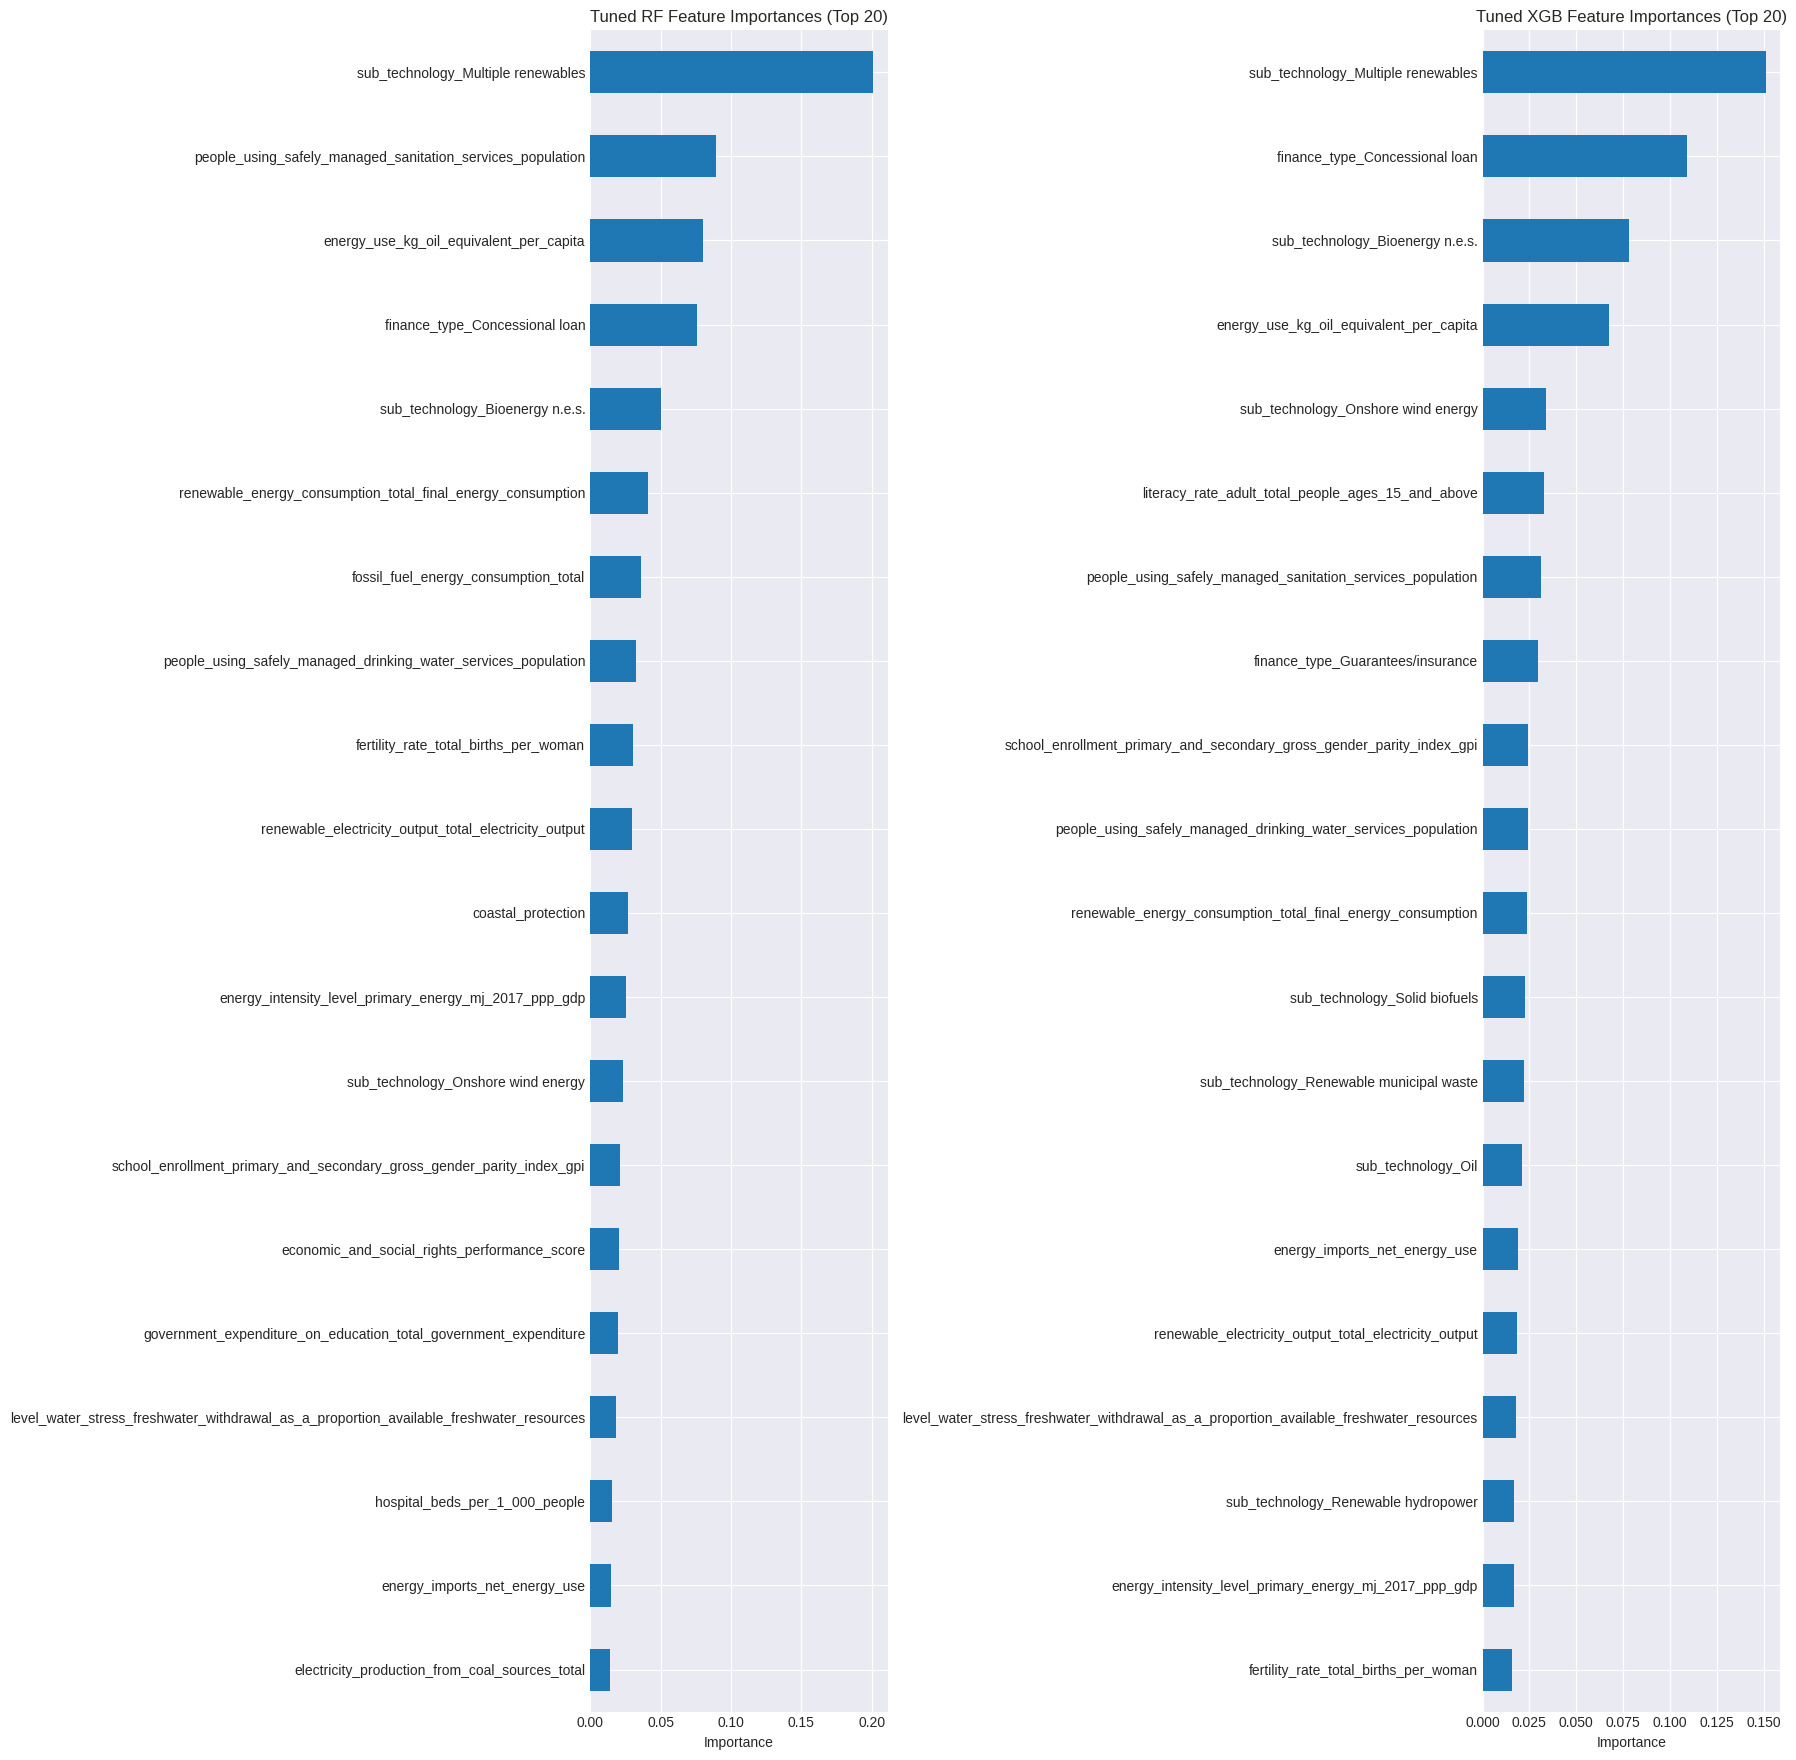


--- SHAP Summary Plots ---


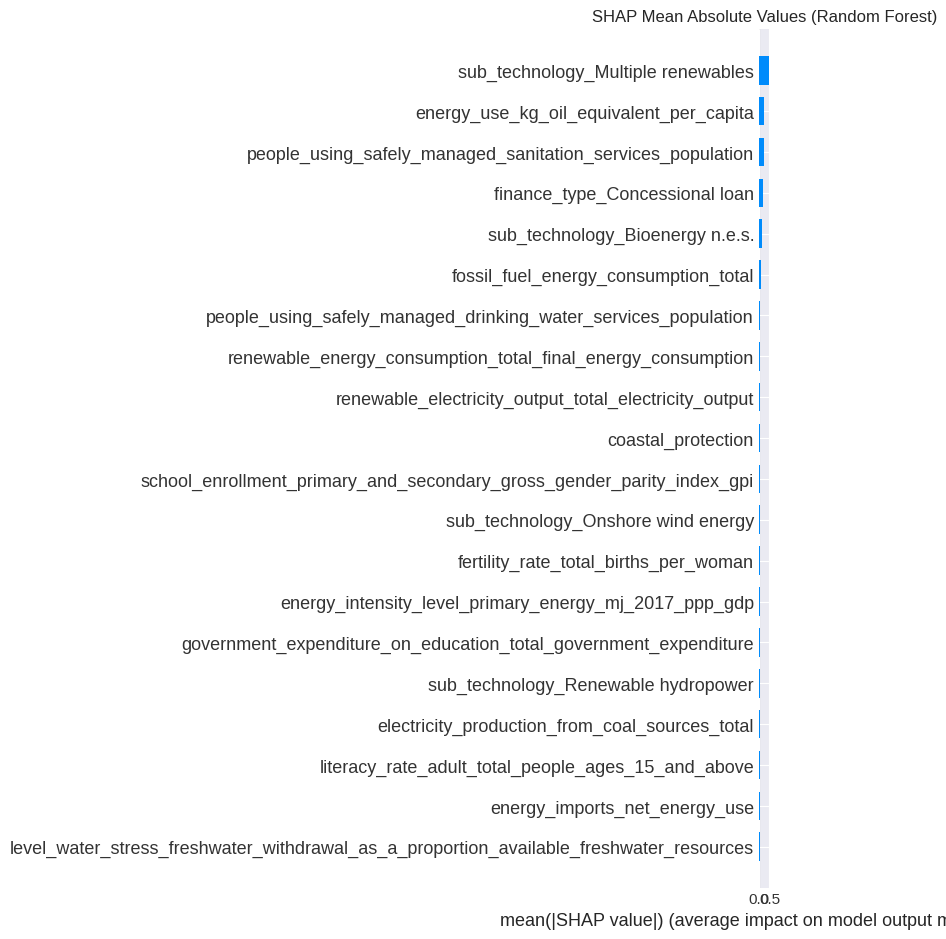

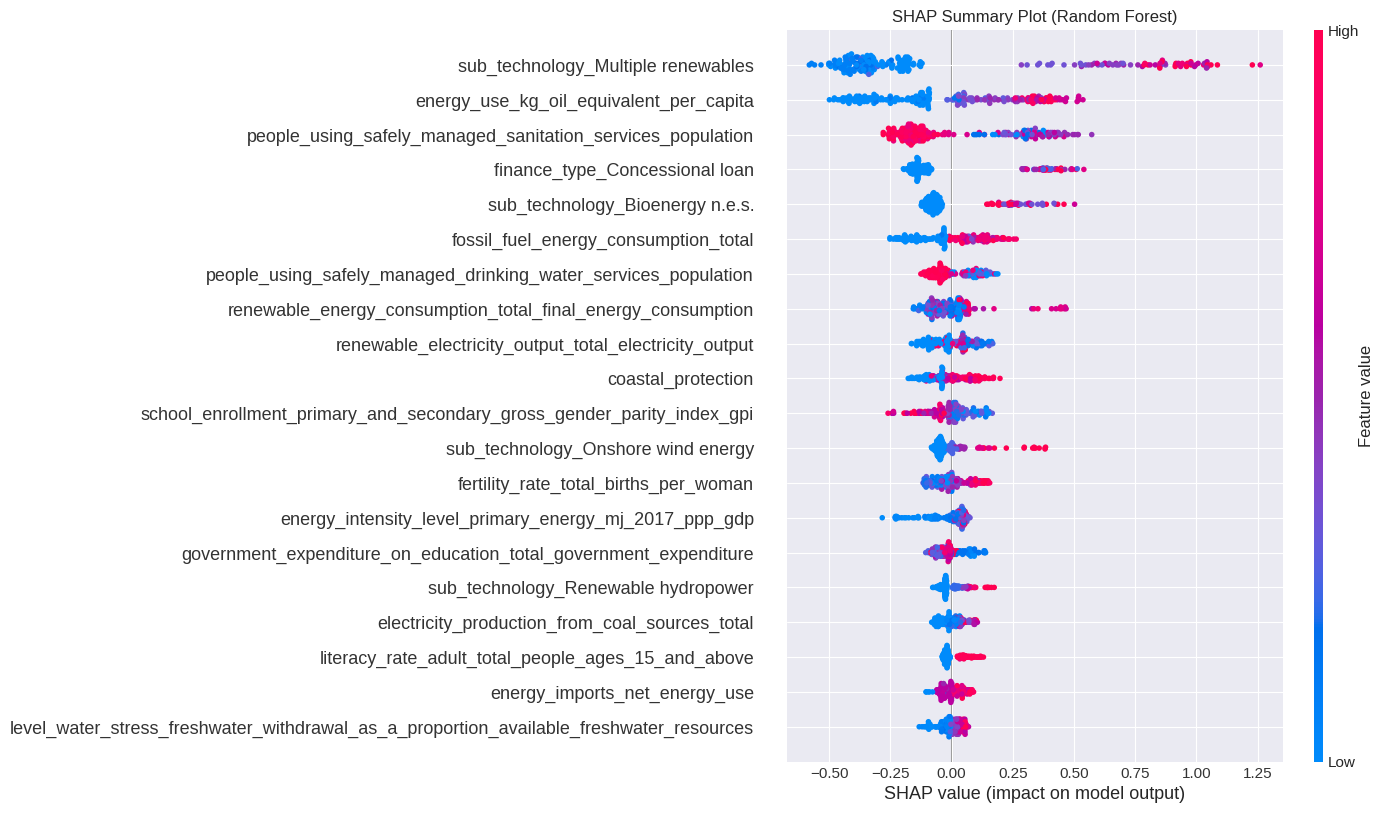

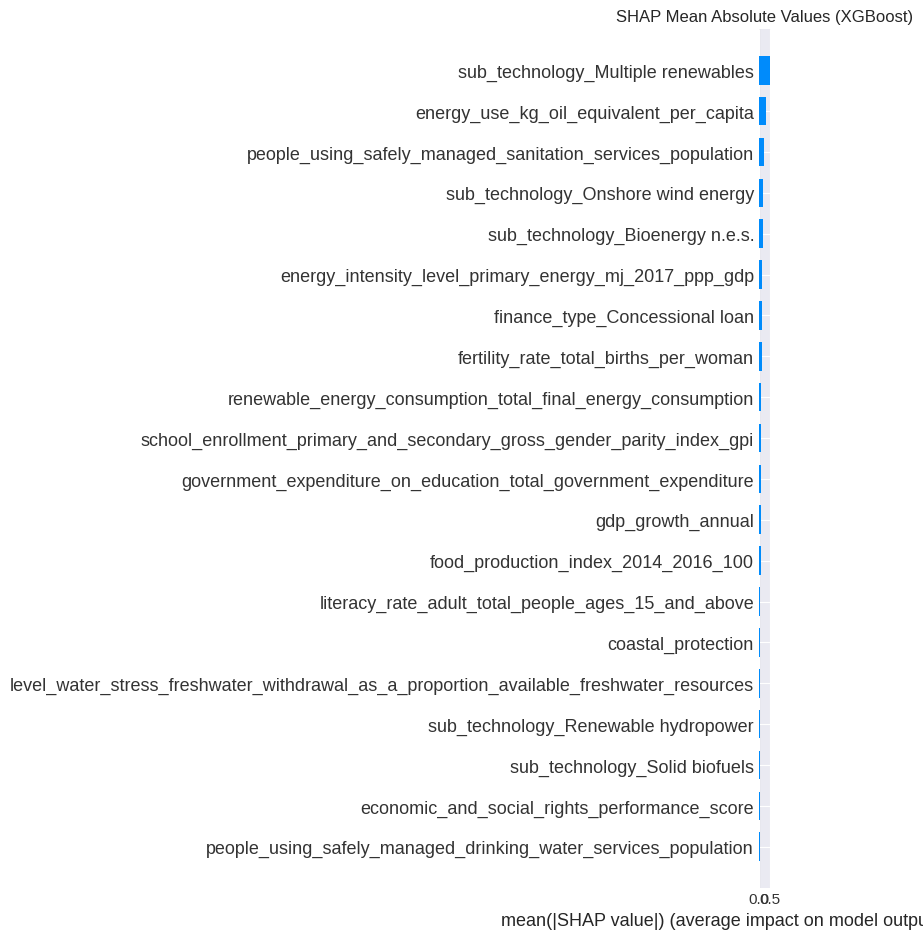

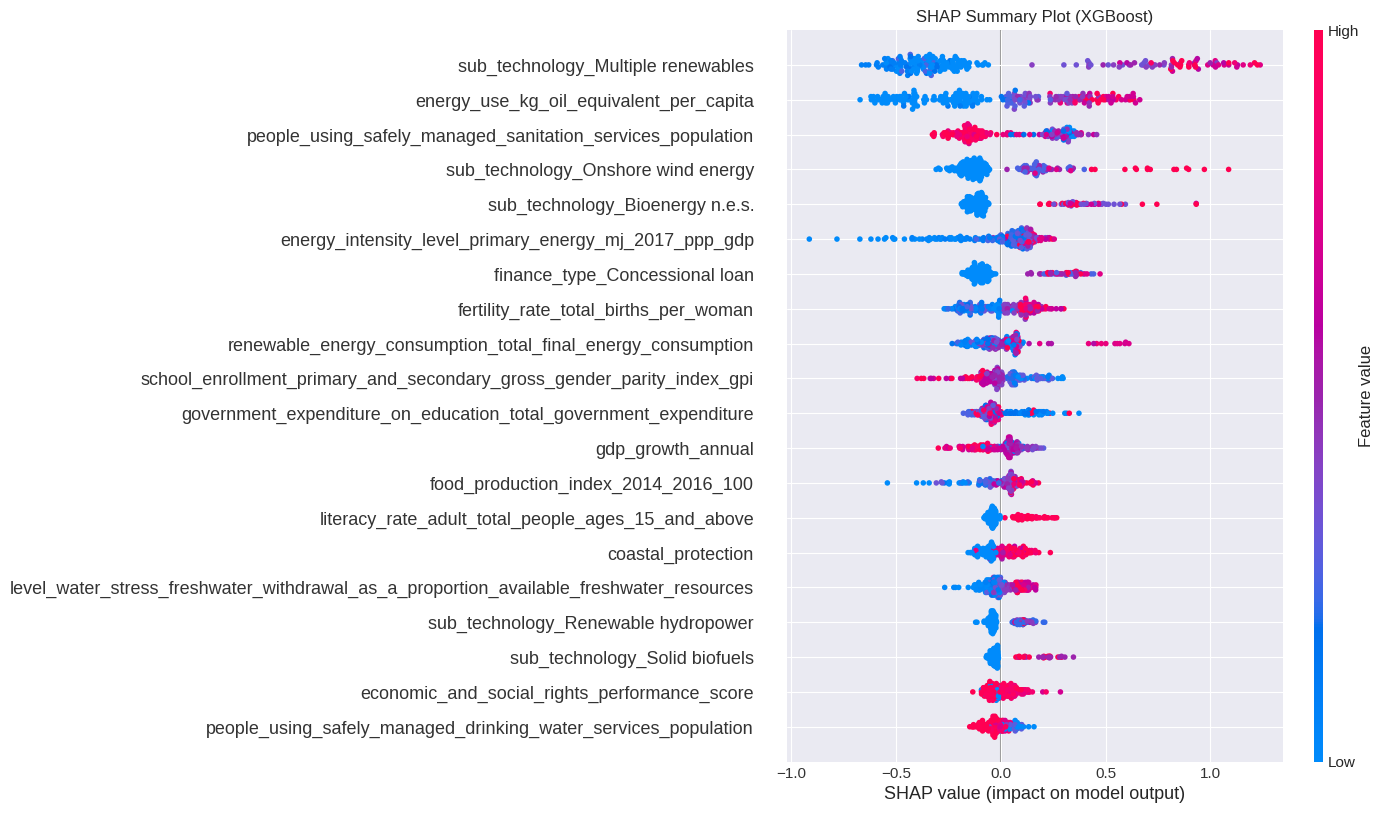


--- Generating Residual Plots ---


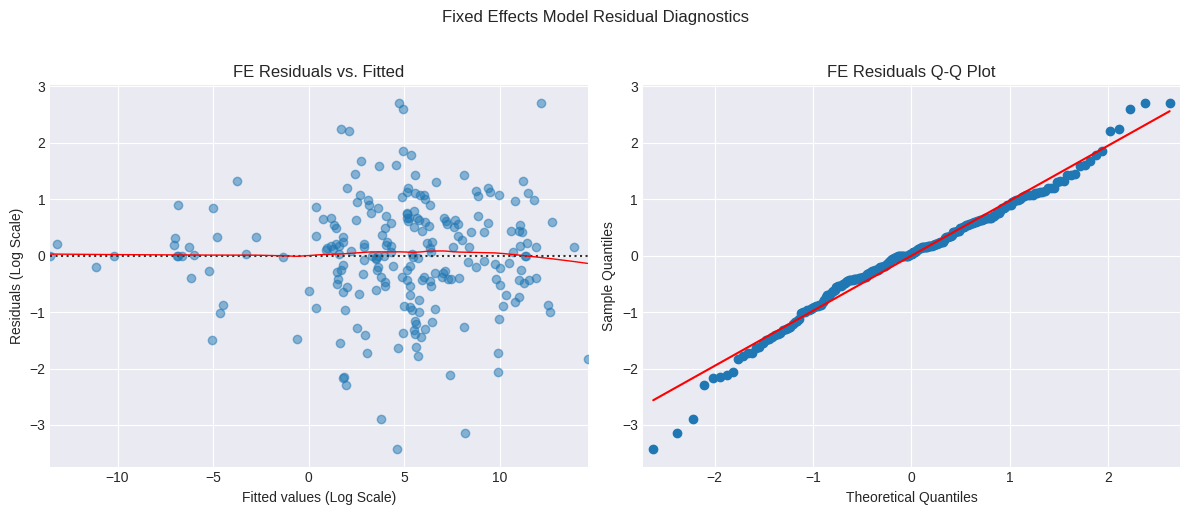

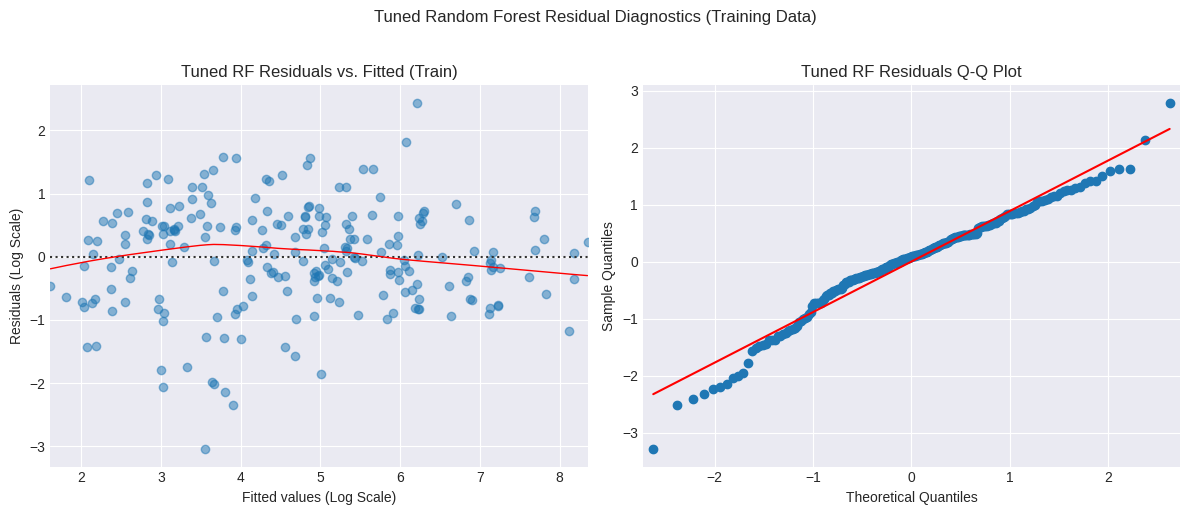


--- Important Considerations & Next Steps ---
1.  **Data Limitation:** The merged sample size (N=228) remains small relative to the number of features, impacting model stability and generalizability.
2.  **Model Interpretation:** Panel model coefficients (esp. FE) can be unstable; interpret with caution. ML feature importance/SHAP provides associative insights but not necessarily causal ones.
3.  **Further Steps:**
    - Acquire more data (years/countries).
    - Explore PCA/Factor Analysis more deeply if VIF still leaves too many features.
    - Consider theory-driven model simplification.
    - Conduct more rigorous robustness checks (e.g., different imputation methods, outlier sensitivity).
    - Integrate qualitative case studies for richer context.

--- Analysis Complete ---


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA # Keep commented unless using PCA path
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None) # Show all rows if needed
pd.set_option('display.max_columns', 100)

# --- 1. Load Data ---
print("--- Loading Data ---")
try:
    esg_df = pd.read_csv('ESG_indicators.csv')
    investment_df = pd.read_csv('PANEL_IRENA_RE_Investment_Processed_VIF_Reduced.csv')
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    exit()

# --- 2. Initial Data Cleaning and Merging ---
print("\n--- Merging DataFrames ---")
# Clean column names
esg_df.columns = esg_df.columns.str.strip()
investment_df.columns = investment_df.columns.str.strip()
investment_df.rename(columns={'amount_usd_million': 'investment_amount_usd_million'}, inplace=True)

# Merge
merged_df = pd.merge(esg_df, investment_df, on=['Country', 'Year'], how='inner')
print(f"Merged DataFrame shape: {merged_df.shape}")

# --- 3. Preprocessing ---
print("\n--- Preprocessing ---")

# Log-transform the target variable
target_col = 'investment_amount_usd_million'
merged_df[target_col + '_log'] = np.log1p(merged_df[target_col])
print(f"Log-transformed target variable '{target_col}_log' created.")

# --- 4. Feature Engineering ---
print("\n--- Feature Engineering ---")

# --- 4.1 Create Composite Governance Index ---
# Select relevant governance columns (assuming these were the original ones before VIF)
gov_cols = ['control_corruption_estimate', 'rule_law_estimate',
            'voice_and_accountability_estimate',
            'political_stability_and_absence_violence_terrorism_estimate']

# Check which governance columns are actually present after merge
gov_cols_present = [col for col in gov_cols if col in merged_df.columns]
print(f"Governance columns present for potential index: {gov_cols_present}")

if len(gov_cols_present) > 1:
    scaler = StandardScaler()
    # Impute missing values within governance columns *before* scaling/averaging (using median)
    for col in gov_cols_present:
        if merged_df[col].isnull().any():
            median_val = merged_df[col].median()
            merged_df[col].fillna(median_val, inplace=True)
            print(f"Imputed missing values in '{col}' with median for Governance Index.")

    # Scale and average
    gov_scaled = scaler.fit_transform(merged_df[gov_cols_present])
    merged_df['Governance_Index'] = np.nanmean(gov_scaled, axis=1) # Use nanmean
    print("Created 'Governance_Index' by averaging scaled governance variables.")
    # Prepare for removing original columns later
    features_to_drop_post_eng = gov_cols_present
else:
    print("Not enough governance columns present to create a composite index.")
    features_to_drop_post_eng = []
    merged_df['Governance_Index'] = np.nan # Create column even if empty for consistency

# --- 4.2 Create Lagged Variables ---
lag_vars = ['gdp_growth_annual', 'Governance_Index'] # Add others if theoretically justified
lags = 1
print(f"Creating {lags}-year lags for: {lag_vars}")
merged_df = merged_df.sort_values(by=['Country', 'Year']) # IMPORTANT: Sort before lagging
for var in lag_vars:
    if var in merged_df.columns:
        merged_df[f'{var}_lag{lags}'] = merged_df.groupby('Country')[var].shift(lags)
    else:
         print(f"Warning: Cannot create lag for '{var}', column not found.")

# --- 4.3 Create Interaction Term ---
# Example: Interaction between R&D expenditure and Governance Index
if 'research_and_development_expenditure_gdp' in merged_df.columns and 'Governance_Index' in merged_df.columns:
    merged_df['RnD_x_Gov'] = merged_df['research_and_development_expenditure_gdp'] * merged_df['Governance_Index']
    print("Created interaction term 'RnD_x_Gov'.")
else:
    print("Could not create interaction term 'RnD_x_Gov' due to missing base columns.")

# --- 4.4 Handle NaNs introduced by Lagging ---
# Simple approach: Drop rows with NaNs in the lagged variables
original_rows = merged_df.shape[0]
cols_to_check_for_nan = [f'{var}_lag{lags}' for var in lag_vars if f'{var}_lag{lags}' in merged_df.columns]
if cols_to_check_for_nan:
    merged_df.dropna(subset=cols_to_check_for_nan, inplace=True)
    print(f"Dropped {original_rows - merged_df.shape[0]} rows due to NaNs from lagging.")
    print(f"Shape after dropping lagged NaNs: {merged_df.shape}")
else:
     print("No lagged variables were successfully created to check for NaNs.")

# --- 5. Define Features and Target (Post-Engineering) ---
# Remove original governance cols if index created, also original cols used for lags/interactions
engineered_features_to_add = [col for col in merged_df.columns if '_lag' in col or '_x_' in col or col == 'Governance_Index']
initial_potential_features = [col for col in merged_df.columns if col not in ['Country', 'Year', target_col, target_col+'_log'] ]

potential_features = (
    [col for col in initial_potential_features if col not in features_to_drop_post_eng] # Remove original gov cols
    + engineered_features_to_add # Add the engineered ones
)
# Ensure no duplicates
potential_features = list(dict.fromkeys(potential_features))

print(f"Potential features after engineering ({len(potential_features)}):") #{potential_features}") # List might be too long

X = merged_df[potential_features].copy()
y = merged_df[target_col].copy()
y_log = merged_df[target_col + '_log'].copy()

# Identify numeric features AGAIN for imputation and VIF
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
print(f"Identified {len(numeric_cols)} numeric columns for processing after feature engineering.")

# Handle Missing Values (for any other columns or potentially introduced NaNs if dropna wasn't used)
print("Handling any remaining missing values using median imputation...")
missing_counts = X[numeric_cols].isnull().sum()
cols_with_missing = missing_counts[missing_counts > 0].index.tolist()
if cols_with_missing:
    print(f"Columns with missing values needing imputation: {cols_with_missing}")
    for col in cols_with_missing:
        median_val = X[col].median()
        X[col].fillna(median_val, inplace=True)
        print(f"Filled missing values in '{col}' with median ({median_val:.2f})")
else:
    print("No missing values found in numeric features after engineering/lag drop.")

print(f"Final X shape before VIF: {X.shape}")

# --- 6. Feature Selection (Re-apply VIF on Engineered Features) ---
print("\n--- Performing VIF on Engineered Feature Set ---")

X_vif = X[numeric_cols].copy()

# Check for zero variance columns again after engineering/dropping NaNs
print("Checking for columns with zero variance...")
cols_zero_variance = X_vif.columns[X_vif.nunique(dropna=False) <= 1]
if not cols_zero_variance.empty:
    print(f"Dropping columns with zero variance: {list(cols_zero_variance)}")
    X_vif = X_vif.drop(columns=cols_zero_variance)
    # Update numeric_cols if any were dropped
    numeric_cols = X_vif.columns.tolist()
else:
    print("No columns with zero variance found.")

if not numeric_cols:
    print("Error: No numeric columns left after zero variance check. Cannot proceed with VIF.")
    final_features = []
else:
    X_vif['const'] = 1 # Add constant
    vif_threshold = 10
    max_vif = vif_threshold + 1
    features_before_vif = set(X_vif.drop(columns=['const']).columns)

    while max_vif > vif_threshold and X_vif.shape[1] > 1: # Ensure at least one feature remains
        vif_data = pd.DataFrame()
        vif_data["feature"] = X_vif.columns
        try:
            vif_values = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
            vif_data["VIF"] = vif_values
        except Exception as e:
            print(f"Error calculating VIF (likely perfect collinearity): {e}")
            # Simple strategy: Drop the last added/remaining feature (excluding const)
            if X_vif.shape[1] > 1:
                 problematic_col = X_vif.columns[-2]
                 print(f"Attempting to drop '{problematic_col}' due to VIF calculation error.")
                 X_vif = X_vif.drop(columns=[problematic_col])
                 features_before_vif = set(X_vif.drop(columns=['const']).columns) # Reset baseline
                 continue
            else:
                 print("Error: Cannot drop more features during VIF error handling.")
                 break


        vif_data = vif_data[vif_data['feature'] != 'const']
        vif_data.dropna(inplace=True)

        if vif_data.empty:
             print("Warning: VIF calculation resulted in an empty dataframe. Stopping VIF loop.")
             break

        max_vif = vif_data['VIF'].max()

        if max_vif > vif_threshold:
            feature_to_drop = vif_data.sort_values('VIF', ascending=False)['feature'].iloc[0]
            if feature_to_drop in X_vif.columns:
                 X_vif = X_vif.drop(columns=[feature_to_drop])
                 print(f"Dropping '{feature_to_drop}' (VIF: {max_vif:.2f})")
            else:
                 print(f"Warning: Feature '{feature_to_drop}' not found for dropping. Stopping.")
                 break
        else:
            print(f"All remaining features have VIF <= {vif_threshold}.")

    final_features = X_vif.drop(columns=['const']).columns.tolist()


# --- Alternative Feature Selection/Dimensionality Reduction (Example - Keep Commented Out) ---
# print("\n--- ALTERNATIVE: PCA ---")
# # Example: PCA on Technology Types
# tech_cols = [col for col in potential_features if 'sub_technology_' in col]
# print(f"Applying PCA to {len(tech_cols)} technology features.")
# X_tech = merged_df[tech_cols].copy()
# # Impute NaNs if any still exist in these specific columns
# X_tech.fillna(X_tech.median(), inplace=True)
# scaler_tech = StandardScaler()
# X_tech_scaled = scaler_tech.fit_transform(X_tech)
# pca_tech = PCA(n_components=0.95) # Keep 95% of variance
# X_pca_tech = pca_tech.fit_transform(X_tech_scaled)
# n_tech_components = X_pca_tech.shape[1]
# print(f"Reduced technology features to {n_tech_components} principal components.")
# pca_tech_cols = [f'Tech_PC_{i+1}' for i in range(n_tech_components)]
# pca_tech_df = pd.DataFrame(X_pca_tech, columns=pca_tech_cols, index=X.index)

# # Example: PCA on Finance Types
# fin_cols = [col for col in potential_features if 'finance_type_' in col]
# print(f"Applying PCA to {len(fin_cols)} finance features.")
# # ... (similar PCA process as above for finance) ...
# pca_fin_cols = [f'Fin_PC_{i+1}' for i in range(n_fin_components)]
# pca_fin_df = pd.DataFrame(X_pca_fin, columns=pca_fin_cols, index=X.index)

# # Combine non-PCA'd features with PCA components
# non_pca_cols = [col for col in X.columns if col not in tech_cols + fin_cols]
# X_pca_final = pd.concat([X[non_pca_cols], pca_tech_df, pca_fin_df], axis=1)
# final_features = X_pca_final.columns.tolist() # Use this list going forward if PCA path chosen
# print(f"Final feature set size after PCA: {len(final_features)}")
# X_final = X_pca_final.copy() # Use X_pca_final if pursuing this route


# --- Continue with the VIF path ---
print(f"\nInitial numeric features before VIF (engineered): {len(features_before_vif)}")
print(f"Features dropped by VIF: {len(features_before_vif - set(final_features))}")
print(f"Final features after VIF ({len(final_features)}):")# {final_features}")
print(f"Number of final numeric features: {len(final_features)}")
# Display final VIFs
if final_features:
    X_final_vif_display = X_vif[final_features].copy()
    X_final_vif_display['const'] = 1
    vif_final_data = pd.DataFrame()
    vif_final_data["feature"] = X_final_vif_display.columns
    try:
        vif_final_data["VIF"] = [variance_inflation_factor(X_final_vif_display.values, i) for i in range(X_final_vif_display.shape[1])]
        vif_final_data = vif_final_data[vif_final_data['feature'] != 'const']
        print("\nFinal VIF Scores:")
        print(vif_final_data.sort_values('VIF', ascending=False))
    except Exception as e:
        print(f"Could not calculate final VIFs: {e}")

X_final = X[final_features].copy() # Define X_final based on VIF outcome

# --- 7. Panel Data Regression (with Diagnostics) ---
print("\n--- Panel Data Regression ---")
if not final_features:
    print("Skipping Panel Regression - No features remaining after VIF.")
else:
    # Set index for panel data models
    panel_data = merged_df.set_index(['Country', 'Year'])
    y_panel = panel_data[target_col + '_log']
    X_panel_pre = panel_data[final_features]
    X_panel_const = sm.add_constant(X_panel_pre)

    # Fit FE and RE models for Hausman test
    print("\n--- Fitting RE and FE for Hausman Test ---")
    try:
        re_model = RandomEffects(y_panel, X_panel_const)
        re_results_h = re_model.fit(cov_type='clustered', cluster_entity=True)
        print("Random Effects Summary (for Hausman):")
        print(re_results_h)

        fe_model = PanelOLS(y_panel, X_panel_const, entity_effects=True)
        fe_results_h = fe_model.fit(cov_type='clustered', cluster_entity=True)
        print("\nFixed Effects (Entity) Summary (for Hausman):")
        print(fe_results_h)

        # Perform Hausman Test (requires manual calculation in recent linearmodels)
        print("\n--- Performing Hausman Test (Manual Calculation) ---")
        common_params = list(set(re_results_h.params.index) & set(fe_results_h.params.index) - {'const'})
        if not common_params:
             print("No common non-constant parameters between RE and FE models, cannot perform Hausman test.")
        else:
            b_re = re_results_h.params.loc[common_params]
            b_fe = fe_results_h.params.loc[common_params]
            cov_re = re_results_h.cov.loc[common_params, common_params]
            cov_fe = fe_results_h.cov.loc[common_params, common_params]

            # Check if cov_fe - cov_re is positive semi-definite (required for Hausman)
            try:
                 diff_cov = cov_fe - cov_re
                 # Add small diagonal increment for numerical stability if needed
                 # diff_cov += np.eye(diff_cov.shape[0]) * 1e-9
                 inv_diff_cov = np.linalg.pinv(diff_cov) # Use pseudo-inverse for stability
                 diff_params = (b_fe - b_re).values

                 hausman_stat = diff_params.T @ inv_diff_cov @ diff_params
                 df_hausman = len(common_params)
                 from scipy.stats import chi2
                 p_value_hausman = 1 - chi2.cdf(hausman_stat, df_hausman)

                 print(f"Hausman Test Statistic: {hausman_stat:.4f}")
                 print(f"Degrees of Freedom: {df_hausman}")
                 print(f"P-value: {p_value_hausman:.4f}")
                 if p_value_hausman < 0.05:
                     print("Hausman test significant (p < 0.05): Suggests Fixed Effects might be preferred over Random Effects.")
                 else:
                     print("Hausman test not significant (p >= 0.05): Suggests Random Effects might be more efficient.")
            except np.linalg.LinAlgError:
                 print("Could not compute Hausman test statistic (matrix inversion issue, possibly due to near-perfect collinearity or small N).")
            except Exception as e:
                 print(f"An error occurred during Hausman test calculation: {e}")

        # Refit preferred model or show both FE/RE results as before
        print("\n--- Refitting Final Panel Models (Example: FE & RE) ---")
        print(fe_results_h) # FE already fitted
        print(re_results_h) # RE already fitted

        # Example with Driscoll-Kraay Standard Errors (useful if T is large relative to N, maybe not ideal here)
        print("\n--- Example: Fixed Effects (Entity) with Driscoll-Kraay SEs ---")
        try:
             # Ensure X_panel_const has the right index
             X_panel_const_dk = sm.add_constant(panel_data[final_features], has_constant='add')
             fe_dk_model = PanelOLS(y_panel, X_panel_const_dk, entity_effects=True)
             # maxlags should be approx T**0.25 or specified
             t_periods = len(panel_data.index.get_level_values('Year').unique())
             maxlags_dk = int(np.floor(t_periods**(1/4)))
             print(f"Using maxlags={maxlags_dk} for Driscoll-Kraay")
             fe_dk_results = fe_dk_model.fit(cov_type='driscoll_kraay', maxlags=maxlags_dk)
             print(fe_dk_results)
        except Exception as e:
             print(f"Could not fit Driscoll-Kraay (may require balanced panel or different maxlags): {e}")

    except Exception as e:
        print(f"Error fitting panel models for Hausman test: {e}")

# --- 8. Machine Learning Models (with CV and Tuning) ---
print("\n--- Machine Learning Models with CV and Tuning ---")
if not final_features or X_final.empty:
    print("Skipping ML models as no features remained after VIF selection.")
else:
    # Prepare data for ML
    groups = merged_df['Country'].astype('category').cat.codes # Groups for GroupKFold
    X_ml = X_final.copy()
    y_ml = y_log.copy()
    y_ml_orig = y.copy()

    # Define CV strategy
    n_splits_cv = 5 # Adjust based on data size
    group_kfold = GroupKFold(n_splits=n_splits_cv)
    cv_strategy = list(group_kfold.split(X_ml, y_ml, groups)) # Generate splits once

    # --- Random Forest with GridSearchCV ---
    print("\n--- Tuning Random Forest with GridSearchCV ---")
    param_grid_rf = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_leaf': [3, 5],
        'max_features': [0.5, 0.7, 1.0] # Fraction or integer
    }
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf,
                                  cv=cv_strategy, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
    try:
        grid_search_rf.fit(X_ml, y_ml)
        print(f"Best RF Parameters: {grid_search_rf.best_params_}")
        best_rf = grid_search_rf.best_estimator_
        # Use best model for final predictions on a held-out set or full data fit
    except Exception as e:
        print(f"GridSearchCV for RF failed: {e}")
        print("Falling back to default RF.")
        best_rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_ml, y_ml)


    # --- XGBoost with GridSearchCV ---
    print("\n--- Tuning XGBoost with GridSearchCV ---")
    param_grid_xgb = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.7, 0.9],
        'colsample_bytree': [0.7, 0.9]
    }
    xgb_model_tuned = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
    grid_search_xgb = GridSearchCV(estimator=xgb_model_tuned, param_grid=param_grid_xgb,
                                   cv=cv_strategy, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
    try:
        grid_search_xgb.fit(X_ml, y_ml)
        print(f"Best XGB Parameters: {grid_search_xgb.best_params_}")
        best_xgb = grid_search_xgb.best_estimator_
    except Exception as e:
         print(f"GridSearchCV for XGB failed: {e}")
         print("Falling back to default XGB.")
         best_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_ml, y_ml)


    # --- 9. Evaluation & Interpretation (Post-Tuning) ---
    print("\n--- Evaluating Tuned Models (Example: using OOB or Train performance) ---")
    # Ideally, evaluate on a separate *hold-out* test set if data permits.
    # Since N is small, we might just look at OOB (RF) or train scores, or full data fit R2.
    if isinstance(best_rf, RandomForestRegressor) and hasattr(best_rf, 'oob_score_'):
         best_rf.fit(X_ml, y_ml) # Refit with oob_score if GridSearchCV didn't enable it
         print(f"Tuned RF OOB Score: {best_rf.oob_score_:.4f}")

    y_pred_log_rf_tuned = best_rf.predict(X_ml)
    y_pred_orig_rf_tuned = np.expm1(np.maximum(y_pred_log_rf_tuned, -50))

    y_pred_log_xgb_tuned = best_xgb.predict(X_ml)
    y_pred_orig_xgb_tuned = np.expm1(np.maximum(y_pred_log_xgb_tuned, -50))

    def evaluate_model_train(name, y_true_orig, y_pred_orig, y_true_log, y_pred_log):
        y_pred_orig = np.nan_to_num(y_pred_orig, nan=0.0, posinf=y_true_orig.max(), neginf=y_true_orig.min())
        y_pred_log = np.nan_to_num(y_pred_log, nan=0.0, posinf=y_true_log.max(), neginf=y_true_log.min())
        r2 = r2_score(y_true_orig, y_pred_orig)
        mae = mean_absolute_error(y_true_orig, y_pred_orig)
        rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
        r2_log = r2_score(y_true_log, y_pred_log)
        mae_log = mean_absolute_error(y_true_log, y_pred_log)
        rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
        print(f"{name} Performance (Full Training Data):")
        print(f"  R2 (Original Scale): {r2:.4f}")
        print(f"  MAE (Original Scale): {mae:.4f}")
        print(f"  RMSE (Original Scale): {rmse:.4f}")
        print(f"  R2 (Log Scale): {r2_log:.4f}")
        print(f"  MAE (Log Scale): {mae_log:.4f}")
        print(f"  RMSE (Log Scale): {rmse_log:.4f}")

    evaluate_model_train("Tuned Random Forest", y_ml_orig, y_pred_orig_rf_tuned, y_ml, y_pred_log_rf_tuned)
    evaluate_model_train("Tuned XGBoost", y_ml_orig, y_pred_orig_xgb_tuned, y_ml, y_pred_log_xgb_tuned)

    # --- SHAP Interpretation ---
    print("\n--- Generating SHAP Values ---")
    try:
        explainer_rf = shap.TreeExplainer(best_rf)
        shap_values_rf = explainer_rf.shap_values(X_ml)
        print("RF SHAP values calculated.")

        explainer_xgb = shap.TreeExplainer(best_xgb)
        shap_values_xgb = explainer_xgb.shap_values(X_ml)
        print("XGB SHAP values calculated.")

        # --- 10. Visualization (Revised) ---
        print("\n--- Generating Visualizations ---")
        plt.style.use('seaborn-v0_8-darkgrid')

        # Feature Importance (using tuned models)
        fig_imp, axes_imp = plt.subplots(1, 2, figsize=(18, max(8, len(final_features) * 0.3)))
        n_features_to_plot = min(20, len(final_features))

        rf_importances_tuned = pd.Series(best_rf.feature_importances_, index=X_ml.columns)
        rf_importances_tuned.nlargest(n_features_to_plot).sort_values().plot(kind='barh', ax=axes_imp[0])
        axes_imp[0].set_title(f'Tuned RF Feature Importances (Top {n_features_to_plot})')
        axes_imp[0].set_xlabel('Importance')

        xgb_importances_tuned = pd.Series(best_xgb.feature_importances_, index=X_ml.columns)
        xgb_importances_tuned.nlargest(n_features_to_plot).sort_values().plot(kind='barh', ax=axes_imp[1])
        axes_imp[1].set_title(f'Tuned XGB Feature Importances (Top {n_features_to_plot})')
        axes_imp[1].set_xlabel('Importance')
        fig_imp.tight_layout()
        plt.show()

        # SHAP Summary Plots
        print("\n--- SHAP Summary Plots ---")
        shap.summary_plot(shap_values_rf, X_ml, plot_type="bar", max_display=n_features_to_plot, show=False)
        plt.title("SHAP Mean Absolute Values (Random Forest)")
        plt.tight_layout()
        plt.show()

        shap.summary_plot(shap_values_rf, X_ml, max_display=n_features_to_plot, show=False)
        plt.title("SHAP Summary Plot (Random Forest)")
        plt.tight_layout()
        plt.show()

        shap.summary_plot(shap_values_xgb, X_ml, plot_type="bar", max_display=n_features_to_plot, show=False)
        plt.title("SHAP Mean Absolute Values (XGBoost)")
        plt.tight_layout()
        plt.show()

        shap.summary_plot(shap_values_xgb, X_ml, max_display=n_features_to_plot, show=False)
        plt.title("SHAP Summary Plot (XGBoost)")
        plt.tight_layout()
        plt.show()


        # --- Residual Plots ---
        print("\n--- Generating Residual Plots ---")
        # Example: Fixed Effects Residuals
        if 'fe_results_h' in locals():
             residuals_fe = fe_results_h.resids
             fitted_fe = fe_results_h.fitted_values
             fig_res, ax_res = plt.subplots(1, 2, figsize=(12, 5))
             sns.residplot(x=fitted_fe, y=residuals_fe, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1}, ax=ax_res[0])
             ax_res[0].set_title('FE Residuals vs. Fitted')
             ax_res[0].set_xlabel('Fitted values (Log Scale)')
             ax_res[0].set_ylabel('Residuals (Log Scale)')

             sm.qqplot(residuals_fe, line='s', ax=ax_res[1])
             ax_res[1].set_title('FE Residuals Q-Q Plot')
             fig_res.suptitle('Fixed Effects Model Residual Diagnostics', y=1.02)
             plt.tight_layout()
             plt.show()
        else:
             print("Fixed Effects model results not available for residual plot.")

        # Example: Random Forest Residuals (on training data)
        residuals_rf_tuned = y_ml - y_pred_log_rf_tuned
        fig_res_rf, ax_res_rf = plt.subplots(1, 2, figsize=(12, 5))
        sns.residplot(x=y_pred_log_rf_tuned, y=residuals_rf_tuned, lowess=True, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red', 'lw': 1}, ax=ax_res_rf[0])
        ax_res_rf[0].set_title('Tuned RF Residuals vs. Fitted (Train)')
        ax_res_rf[0].set_xlabel('Fitted values (Log Scale)')
        ax_res_rf[0].set_ylabel('Residuals (Log Scale)')

        sm.qqplot(residuals_rf_tuned, line='s', ax=ax_res_rf[1])
        ax_res_rf[1].set_title('Tuned RF Residuals Q-Q Plot')
        fig_res_rf.suptitle('Tuned Random Forest Residual Diagnostics (Training Data)', y=1.02)
        plt.tight_layout()
        plt.show()

    except ImportError:
        print("SHAP library not found. Skipping SHAP plots.")
    except Exception as e:
        print(f"An error occurred during visualization or SHAP analysis: {e}")

# --- Final Notes ---
print("\n--- Important Considerations & Next Steps ---")
print(f"1.  **Data Limitation:** The merged sample size (N={merged_df.shape[0]}) remains small relative to the number of features, impacting model stability and generalizability.")
print("2.  **Model Interpretation:** Panel model coefficients (esp. FE) can be unstable; interpret with caution. ML feature importance/SHAP provides associative insights but not necessarily causal ones.")
print("3.  **Further Steps:**")
print("    - Acquire more data (years/countries).")
print("    - Explore PCA/Factor Analysis more deeply if VIF still leaves too many features.")
print("    - Consider theory-driven model simplification.")
print("    - Conduct more rigorous robustness checks (e.g., different imputation methods, outlier sensitivity).")
print("    - Integrate qualitative case studies for richer context.")


# --- End of Script ---
print("\n--- Analysis Complete ---")

### Explanation and Workflow:

Load Data: The script starts by loading the two CSV files (ESG_indicators.csv and the processed investment data) into pandas DataFrames. Basic info is printed for verification.

Merge Data: The dataframes are merged based on 'Country' and 'Year' using an inner merge, ensuring only rows with data in both files are kept. Column names are stripped of extra spaces. The investment amount column is renamed for clarity.

Preprocessing:

The target variable (investment_amount_usd_million) is identified.

A log transformation (np.log1p) is applied to the target variable to handle skewness and potential zeros. This often improves model performance, especially for linear models.

Potential predictor features are identified (all columns except identifiers and the target).

Numeric features are selected for imputation and VIF.

Missing values in numeric features are imputed using the median value of each column. This is a simple but robust strategy.

VIF for Multicollinearity:

Variance Inflation Factor (VIF) is calculated iteratively to remove features with high multicollinearity (VIF > 10).

The feature with the highest VIF above the threshold is dropped in each step until all remaining features are below the threshold.

The script prints which features are dropped and the final list of features used for modeling.

Panel Data Regression (linearmodels):

The DataFrame index is set to ['Country', 'Year'] to prepare for panel models.

The log-transformed target (y_panel) and the VIF-reduced features (X_panel_const, including a constant) are defined.

Several standard panel models are fitted and their summary results printed:

Pooled OLS: Ignores panel structure (baseline).

Fixed Effects (Entity): Controls for country-specific time-invariant effects.

Fixed Effects (Time): Controls for time-specific effects common across all countries.

Fixed Effects (Two-way): Controls for both entity and time effects.

Random Effects (Entity): Assumes country-specific effects are random and uncorrelated with predictors.

Clustered standard errors (by entity or time, or both) are used, which is standard practice for panel data to account for within-group correlation.

A note about the Hausman test (comparing FE and RE) is included.

Machine Learning Models:

Train-Test Split: A time-based split is performed. Data up to cutoff_year (2017 in this case) is used for training, and data after that year is used for testing. This respects the temporal nature of the data better than a random split.

The VIF-reduced features (X_final) and the log-transformed target are used for training the ML models. The original scale target for the test set is kept for evaluation.

Random Forest: A RandomForestRegressor is trained. oob_score=True provides an out-of-bag estimate of performance during training. Hyperparameters like n_estimators, max_features, and min_samples_leaf are set (these could be tuned further).

XGBoost: An XGBRegressor is trained. Basic hyperparameters are set (these could also be tuned).

Predictions are made on the test set using both models (initially on the log scale).

Predictions are transformed back to the original scale using np.expm1 for evaluation.

Model Evaluation:

A function evaluate_model is defined to calculate R-squared, Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE) for both the original and log scales of the target variable.

This function is used to evaluate the Random Forest and XGBoost models on the test set. Results are printed.

Visualization:

Feature Importance: Bar plots show the top 20 most important features according to both Random Forest and XGBoost. This helps interpret what drives the predictions in these models.

Actual vs. Predicted: Scatter plots compare the actual investment amounts (original scale) against the predicted amounts from RF and XGBoost on the test set. A diagonal line (y=x) is added to show ideal performance. The R-squared value (on the original scale) is included in the titles.


--- Preprocessing ---
Log-transformed target variable 'investment_amount_usd_million_log' created and added to DataFrame.
Identified 73 numeric columns for processing.
Handling missing values using median imputation...
No missing values found in numeric features.
Remaining NaNs in numeric features after imputation: 0

--- Performing VIF for Multicollinearity ---
Checking for columns with zero variance...
Dropping columns with zero variance: ['finance_type_Capital subscription on deposit basis', 'finance_type_Other hybrid instruments']
Dropping 'finance_type_Other debt securities' (VIF: inf)
Dropping 'finance_type_Standard loan' (VIF: 7179.41)
Dropping 'rule_law_estimate' (VIF: 61.14)
Dropping 'finance_type_Standard grant' (VIF: 42.51)
Dropping 'control_corruption_estimate' (VIF: 29.67)
Dropping 'individuals_using_the_internet_population' (VIF: 19.57)
Dropping 'voice_and_accountability_estimate' (VIF: 16.84)
Dropping 'population_ages_65_and_above_total_population' (VIF: 16.05)
Dropping

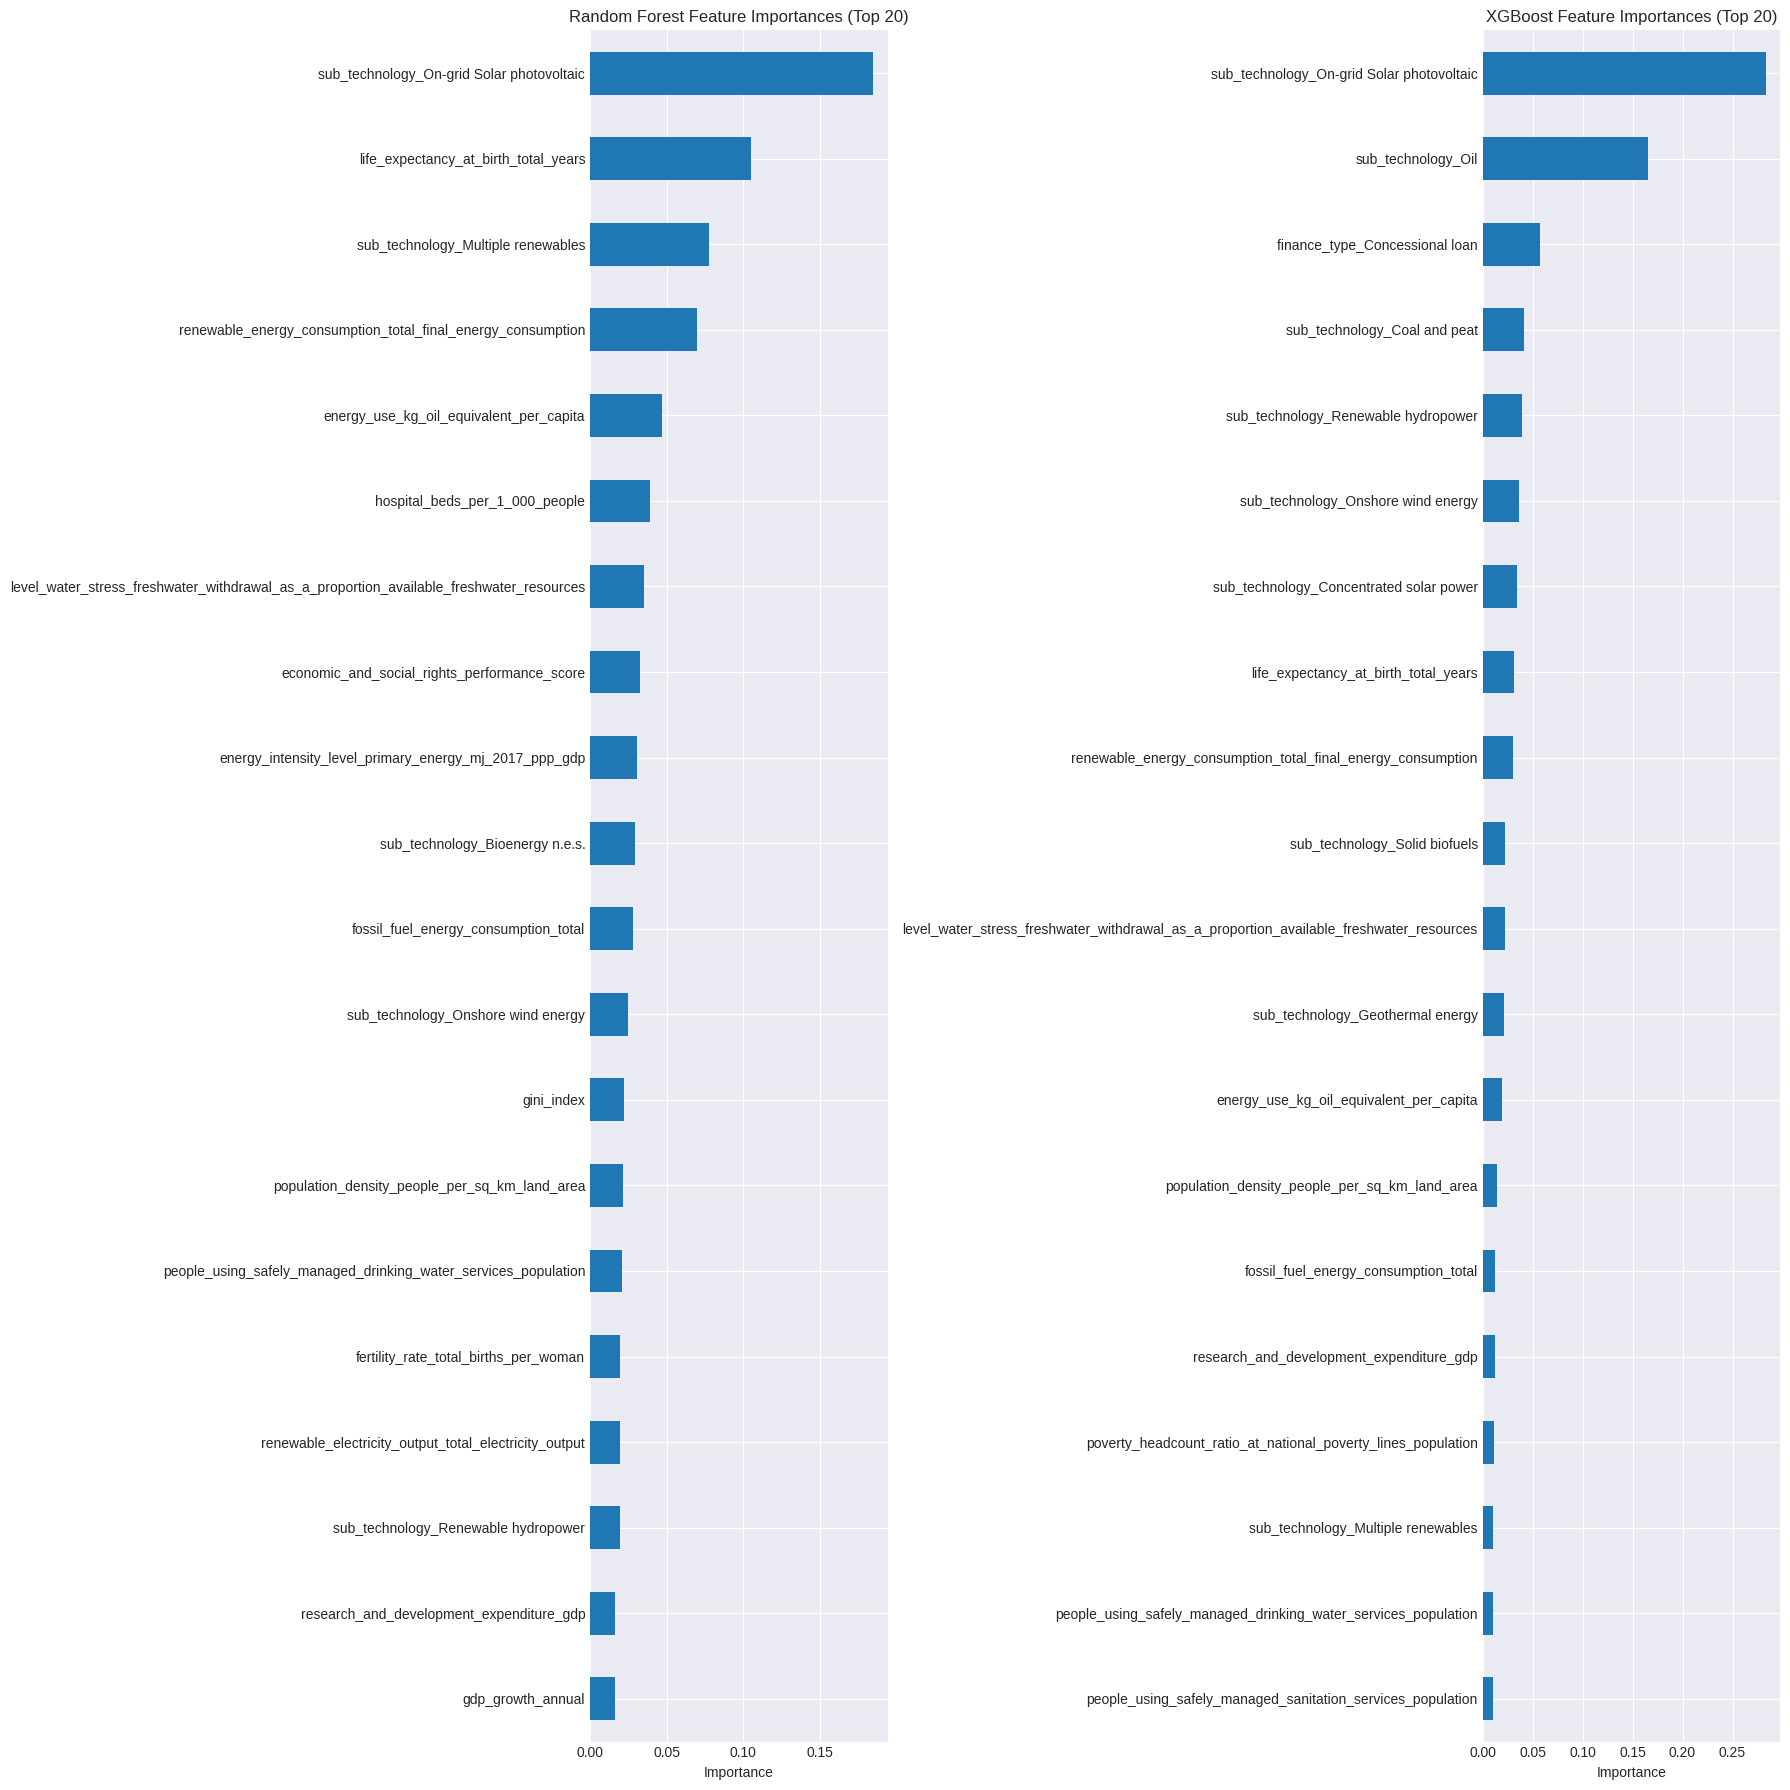

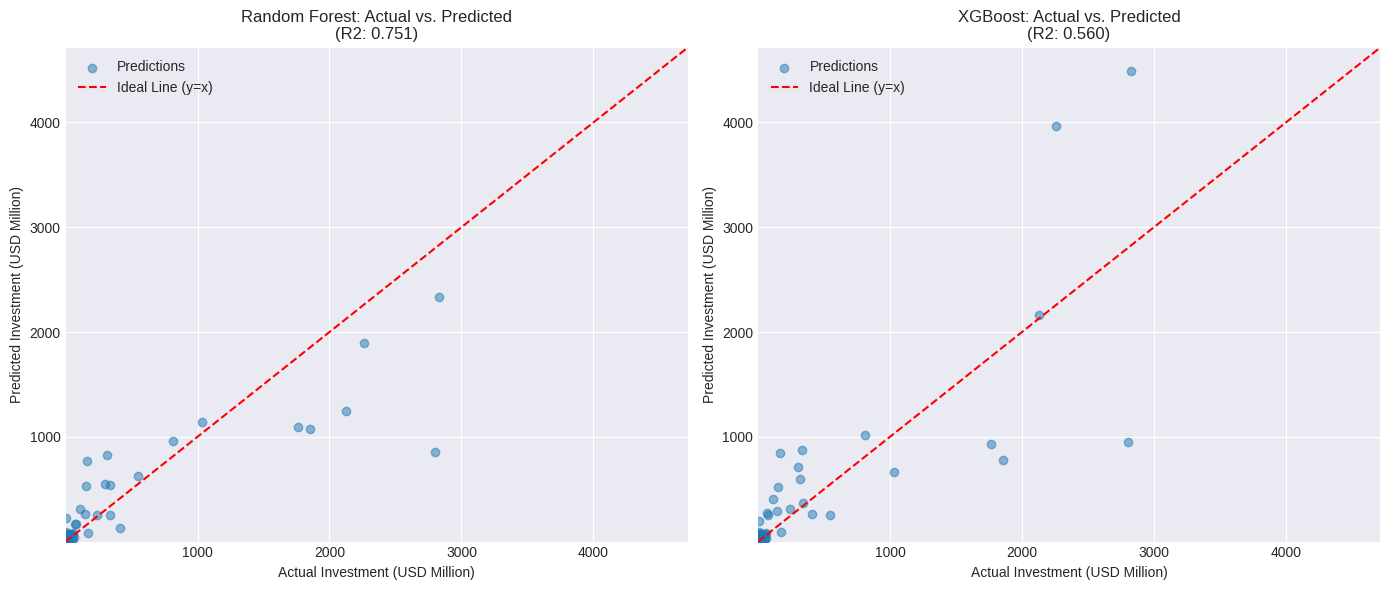


--- Analysis Complete ---


In [ ]:
# --- 3. Preprocessing ---
print("\n--- Preprocessing ---")

# Define target and potential features
target_col = 'investment_amount_usd_million'
# Start with all columns except identifiers and target
potential_features = [col for col in merged_df.columns if col not in ['Country', 'Year', target_col]]

# Separate features (X) and target (y)
X = merged_df[potential_features].copy()
y = merged_df[target_col].copy()

# Log-transform the target variable due to potential skewness (add small constant for stability)
y_log = np.log1p(y)
# >>> FIX: Add the log-transformed target back to the merged DataFrame <<<
merged_df[target_col + '_log'] = y_log
print(f"Log-transformed target variable '{target_col}_log' created and added to DataFrame.")

# Identify numeric features for imputation and VIF
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
print(f"Identified {len(numeric_cols)} numeric columns for processing.")

# Handle Missing Values - Median Imputation (simple strategy for now)
print("Handling missing values using median imputation...")
missing_counts = X[numeric_cols].isnull().sum()
cols_with_missing = missing_counts[missing_counts > 0].index.tolist()
if cols_with_missing:
    print(f"Columns with missing values: {cols_with_missing}")
    for col in cols_with_missing:
        median_val = X[col].median()
        X[col].fillna(median_val, inplace=True)
        print(f"Filled missing values in '{col}' with median ({median_val:.2f})")
else:
    print("No missing values found in numeric features.")

# Check for any remaining NaNs (should be none in numeric cols now)
print(f"Remaining NaNs in numeric features after imputation: {X[numeric_cols].isnull().sum().sum()}")

# --- 4. Feature Selection using VIF ---
print("\n--- Performing VIF for Multicollinearity ---")

# Add constant for VIF calculation
X_vif = X[numeric_cols].copy()

# --- FIX for NaN VIFs: Check for zero variance columns and drop them first ---
print("Checking for columns with zero variance...")
cols_zero_variance = X_vif.columns[X_vif.nunique() == 1]
if not cols_zero_variance.empty:
    print(f"Dropping columns with zero variance: {list(cols_zero_variance)}")
    X_vif = X_vif.drop(columns=cols_zero_variance)
else:
    print("No columns with zero variance found.")
# --------------------------------------------------------------------------

X_vif['const'] = 1 # Add constant *after* checking variance


vif_threshold = 10 # Common threshold
max_vif = vif_threshold + 1 # Initialize max_vif to enter the loop
features_before_vif = set(X_vif.drop(columns=['const']).columns)

while max_vif > vif_threshold:
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif.columns
    # Handle potential perfect collinearity leading to NaN VIFs within the loop
    try:
        vif_values = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    except Exception as e:
        print(f"Error calculating VIF (likely perfect collinearity): {e}")
        # Attempt to identify and drop the problematic column (often the last one added/kept)
        problematic_col = X_vif.columns[-2] # Usually the last non-const feature if const is added
        print(f"Attempting to drop '{problematic_col}' due to VIF calculation error.")
        X_vif = X_vif.drop(columns=[problematic_col])
        features_before_vif = set(X_vif.drop(columns=['const']).columns) # Reset baseline
        continue # Restart VIF calculation

    vif_data["VIF"] = vif_values
    vif_data = vif_data[vif_data['feature'] != 'const'] # Remove constant row
    vif_data.dropna(inplace=True) # Drop features that couldn't calculate VIF (might happen if variance is zero)

    if vif_data.empty:
         print("Warning: VIF calculation resulted in an empty dataframe. Stopping VIF loop.")
         break

    max_vif = vif_data['VIF'].max()

    if max_vif > vif_threshold:
        feature_to_drop = vif_data.sort_values('VIF', ascending=False)['feature'].iloc[0]
        # --- Ensure feature exists before dropping ---
        if feature_to_drop in X_vif.columns:
            X_vif = X_vif.drop(columns=[feature_to_drop])
            print(f"Dropping '{feature_to_drop}' (VIF: {max_vif:.2f})")
        else:
             print(f"Warning: Attempted to drop '{feature_to_drop}' but it was not found. Skipping.")
             # Break to avoid infinite loop if something strange happened
             break
        # -------------------------------------------
    else:
        print(f"All remaining features have VIF <= {vif_threshold}.")


final_features = X_vif.drop(columns=['const']).columns.tolist()
features_dropped_vif = features_before_vif - set(final_features)

print(f"\nInitial numeric features before VIF (after zero variance check): {len(features_before_vif)}")
print(f"Features dropped by VIF: {len(features_dropped_vif)}")
# print(f"Dropped features: {list(features_dropped_vif)}")
print(f"Final features after VIF ({len(final_features)}):") # {final_features}")
print(f"Number of final numeric features: {len(final_features)}")

# Recalculate VIF for the final set to display
if not final_features:
    print("No features remaining after VIF.")
else:
    X_final_vif_display = X_vif[final_features].copy() # Use the dropped X_vif's final state
    X_final_vif_display['const'] = 1
    vif_final_data = pd.DataFrame()
    vif_final_data["feature"] = X_final_vif_display.columns
    try:
        vif_final_data["VIF"] = [variance_inflation_factor(X_final_vif_display.values, i) for i in range(X_final_vif_display.shape[1])]
        vif_final_data = vif_final_data[vif_final_data['feature'] != 'const']
        print(vif_final_data.sort_values('VIF', ascending=False))
    except Exception as e:
        print(f"Could not calculate final VIFs: {e}")


# Update X to only include final features
X_final = X[final_features].copy()


# --- 5. Panel Data Regression ---
print("\n--- Panel Data Regression ---")
# Set index for panel data models
panel_data = merged_df.set_index(['Country', 'Year'])
# Now this line should work as the column exists in panel_data
y_panel = panel_data[target_col + '_log']
X_panel_pre = panel_data[final_features]
# Add constant for statsmodels/linearmodels
X_panel_const = sm.add_constant(X_panel_pre)

# --- Rest of the Panel models, ML models, Evaluation, and Visualization code follows ---
# ... (previous code from point 5 onwards) ...

# --- Pooled OLS ---
print("\n--- Fitting Pooled OLS ---")
try:
    pooled_ols_model = PooledOLS(y_panel, X_panel_const)
    pooled_ols_results = pooled_ols_model.fit(cov_type='clustered', cluster_entity=True)
    print(pooled_ols_results)
except Exception as e:
    print(f"Error fitting Pooled OLS: {e}")

# --- Fixed Effects (Entity) ---
print("\n--- Fitting Fixed Effects (Entity) ---")
try:
    fe_entity_model = PanelOLS(y_panel, X_panel_const, entity_effects=True)
    fe_entity_results = fe_entity_model.fit(cov_type='clustered', cluster_entity=True)
    print(fe_entity_results)
except Exception as e:
    print(f"Error fitting Fixed Effects (Entity): {e}")


# --- Fixed Effects (Time) ---
print("\n--- Fitting Fixed Effects (Time) ---")
try:
    fe_time_model = PanelOLS(y_panel, X_panel_const, time_effects=True)
    fe_time_results = fe_time_model.fit(cov_type='clustered', cluster_time=True) # Cluster by time
    print(fe_time_results)
except Exception as e:
    print(f"Error fitting Fixed Effects (Time): {e}")

# --- Fixed Effects (Two-way: Entity + Time) ---
print("\n--- Fitting Fixed Effects (Two-way: Entity + Time) ---")
try:
    fe_twoway_model = PanelOLS(y_panel, X_panel_const, entity_effects=True, time_effects=True)
    fe_twoway_results = fe_twoway_model.fit(cov_type='clustered', cluster_entity=True, cluster_time=True) # Double cluster
    print(fe_twoway_results)
except Exception as e:
    print(f"Error fitting Fixed Effects (Two-way): {e}")


# --- Random Effects ---
print("\n--- Fitting Random Effects ---")
try:
    re_model = RandomEffects(y_panel, X_panel_const)
    re_results = re_model.fit(cov_type='clustered', cluster_entity=True)
    print(re_results)
except Exception as e:
    print(f"Error fitting Random Effects: {e}")

print("\nNote on FE vs RE: A Hausman test typically compares Fixed vs Random effects.")
print("If the test is significant, it suggests correlation between unobserved effects and predictors, favoring FE.")
print("Otherwise, RE might be more efficient. Both results are presented here.")

# --- 6. Machine Learning Models ---
print("\n--- Machine Learning Models ---")

# Time-based Split (Example: Train up to 2017, Test on 2018+)
cutoff_year = 2017
# Use .loc to avoid potential index issues if rows were dropped during merge/cleaning
train_indices = merged_df.loc[merged_df['Year'] <= cutoff_year].index
test_indices = merged_df.loc[merged_df['Year'] > cutoff_year].index

# Ensure X_final and y_log have the same index as merged_df before slicing
X_final.index = merged_df.index
y_log.index = merged_df.index
y.index = merged_df.index


if not final_features: # Check if features remain after VIF
    print("Skipping ML models as no features remained after VIF selection.")
else:
    X_train, X_test = X_final.loc[train_indices], X_final.loc[test_indices]
    # Use the y_log *column* from merged_df now for consistency
    y_train, y_test = merged_df.loc[train_indices, target_col + '_log'], merged_df.loc[test_indices, target_col + '_log']
    y_test_orig = y.loc[test_indices] # Original scale for evaluation comparison


    print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")
    if X_test.shape[0] == 0:
        print("Warning: Test set is empty. Cannot evaluate ML models. Adjust cutoff_year.")
    else:
        # --- Random Forest ---
        print("\n--- Fitting Random Forest ---")
        rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1,
                                         oob_score=True, max_features=0.5, min_samples_leaf=5)
        rf_model.fit(X_train, y_train)
        y_pred_log_rf = rf_model.predict(X_test)
        # Clamp predictions to avoid issues with expm1 if predictions are large negatives
        y_pred_log_rf = np.maximum(y_pred_log_rf, -50) # Clamp at a reasonable lower bound
        y_pred_orig_rf = np.expm1(y_pred_log_rf) # Transform back to original scale

        print(f"RF OOB Score: {rf_model.oob_score_:.4f}")

        # --- XGBoost ---
        print("\n--- Fitting XGBoost ---")
        xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42,
                                     n_jobs=-1, learning_rate=0.1, max_depth=5, subsample=0.8,
                                     colsample_bytree=0.8)
        xgb_model.fit(X_train, y_train)
        y_pred_log_xgb = xgb_model.predict(X_test)
         # Clamp predictions
        y_pred_log_xgb = np.maximum(y_pred_log_xgb, -50)
        y_pred_orig_xgb = np.expm1(y_pred_log_xgb) # Transform back to original scale


        # --- 7. Model Evaluation ---
        print("\n--- Machine Learning Model Evaluation (Test Set) ---")

        def evaluate_model(name, y_true_orig, y_pred_orig, y_true_log, y_pred_log):
            # Handle potential NaN/Inf in predictions before evaluation
            y_pred_orig = np.nan_to_num(y_pred_orig, nan=0.0, posinf=y_true_orig.max(), neginf=y_true_orig.min())
            y_pred_log = np.nan_to_num(y_pred_log, nan=0.0, posinf=y_true_log.max(), neginf=y_true_log.min())

            r2 = r2_score(y_true_orig, y_pred_orig)
            mae = mean_absolute_error(y_true_orig, y_pred_orig)
            rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
            r2_log = r2_score(y_true_log, y_pred_log)
            mae_log = mean_absolute_error(y_true_log, y_pred_log)
            rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
            print(f"{name} Performance:")
            print(f"  R2 (Original Scale): {r2:.4f}")
            print(f"  MAE (Original Scale): {mae:.4f}")
            print(f"  RMSE (Original Scale): {rmse:.4f}")
            print(f"  R2 (Log Scale): {r2_log:.4f}")
            print(f"  MAE (Log Scale): {mae_log:.4f}")
            print(f"  RMSE (Log Scale): {rmse_log:.4f}")
            return {'R2_orig': r2, 'MAE_orig': mae, 'RMSE_orig': rmse,
                    'R2_log': r2_log, 'MAE_log': mae_log, 'RMSE_log': rmse_log}

        rf_metrics = evaluate_model("Random Forest", y_test_orig, y_pred_orig_rf, y_test, y_pred_log_rf)
        xgb_metrics = evaluate_model("XGBoost", y_test_orig, y_pred_orig_xgb, y_test, y_pred_log_xgb)

        # --- 8. Visualization ---
        print("\n--- Generating Visualizations ---")
        plt.style.use('seaborn-v0_8-darkgrid')

        # Feature Importance
        fig_imp, axes_imp = plt.subplots(1, 2, figsize=(18, max(8, len(final_features) * 0.3))) # Adjust height dynamically
        n_features_to_plot = min(20, len(final_features)) # Plot max 20 or all if fewer

        # RF Importance
        rf_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
        rf_importances.nlargest(n_features_to_plot).sort_values().plot(kind='barh', ax=axes_imp[0])
        axes_imp[0].set_title(f'Random Forest Feature Importances (Top {n_features_to_plot})')
        axes_imp[0].set_xlabel('Importance')

        # XGBoost Importance
        xgb_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
        xgb_importances.nlargest(n_features_to_plot).sort_values().plot(kind='barh', ax=axes_imp[1])
        axes_imp[1].set_title(f'XGBoost Feature Importances (Top {n_features_to_plot})')
        axes_imp[1].set_xlabel('Importance')

        fig_imp.tight_layout()
        plt.show()


        # Actual vs. Predicted Plot (Original Scale)
        fig_pred, axes_pred = plt.subplots(1, 2, figsize=(14, 6))

        # Ensure valid range calculation, handling potential NaNs or Infs from predictions if any
        valid_preds_rf = y_pred_orig_rf[np.isfinite(y_pred_orig_rf)]
        valid_preds_xgb = y_pred_orig_xgb[np.isfinite(y_pred_orig_xgb)]
        all_valid_values = np.concatenate([y_test_orig.values, valid_preds_rf, valid_preds_xgb])

        if len(all_valid_values) > 0:
             max_val = all_valid_values.max() * 1.05
             min_val = max(0, all_valid_values.min() * 0.95) # Ensure min is not negative
        else:
            min_val, max_val = 0, 1 # Default range if no valid data

        # RF Predictions
        axes_pred[0].scatter(y_test_orig, y_pred_orig_rf, alpha=0.5, label='Predictions')
        axes_pred[0].plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Line (y=x)')
        axes_pred[0].set_title(f'Random Forest: Actual vs. Predicted\n(R2: {rf_metrics["R2_orig"]:.3f})')
        axes_pred[0].set_xlabel('Actual Investment (USD Million)')
        axes_pred[0].set_ylabel('Predicted Investment (USD Million)')
        axes_pred[0].set_xlim(min_val, max_val)
        axes_pred[0].set_ylim(min_val, max_val)
        axes_pred[0].legend()
        axes_pred[0].grid(True)

        # XGBoost Predictions
        axes_pred[1].scatter(y_test_orig, y_pred_orig_xgb, alpha=0.5, label='Predictions')
        axes_pred[1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Line (y=x)')
        axes_pred[1].set_title(f'XGBoost: Actual vs. Predicted\n(R2: {xgb_metrics["R2_orig"]:.3f})')
        axes_pred[1].set_xlabel('Actual Investment (USD Million)')
        axes_pred[1].set_ylabel('Predicted Investment (USD Million)')
        axes_pred[1].set_xlim(min_val, max_val)
        axes_pred[1].set_ylim(min_val, max_val)
        axes_pred[1].legend()
        axes_pred[1].grid(True)

        fig_pred.tight_layout()
        plt.show()

# --- End of Script ---
print("\n--- Analysis Complete ---")